In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : True,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'native','im':'t1','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'diffusion_fa',
    'balance_data'  : True,
    'balance_bins'  : 40,
    'balance_ratio' : 0.5,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_MSE_7_40_1_05_0_0_0_1_t1t2_normalized_e_n_e_0_1_e_1_0_diffusion_fa_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_1_42_n_native_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(631390, 828)
(631390, 1)
validation
(74368, 828)
(74368, 1)
test
(85358, 828)
(85358, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 1024)              848896    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 1538049 (5.87 MB)


Trainable params: 1538049 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/64 [..............................] - ETA: 1:19 - loss: 0.1823 - STD: 1.0475e-04 - MAE: 0.4152

 4/64 [>.............................] - ETA: 1s - loss: 0.0626 - STD: 3.9858e-04 - MAE: 0.1935  

 5/64 [=>............................] - ETA: 2s - loss: 0.0538 - STD: 3.6072e-04 - MAE: 0.1752

 6/64 [=>............................] - ETA: 2s - loss: 0.0487 - STD: 3.2193e-04 - MAE: 0.1658

 7/64 [==>...........................] - ETA: 2s - loss: 0.0454 - STD: 2.8801e-04 - MAE: 0.1603

 8/64 [==>...........................] - ETA: 2s - loss: 0.0432 - STD: 2.5914e-04 - MAE: 0.1571

 9/64 [===>..........................] - ETA: 2s - loss: 0.0416 - STD: 2.3480e-04 - MAE: 0.1549

10/64 [===>..........................] - ETA: 2s - loss: 0.0404 - STD: 2.1412e-04 - MAE: 0.1535

11/64 [====>.........................] - ETA: 2s - loss: 0.0393 - STD: 1.9645e-04 - MAE: 0.1521

12/64 [====>.........................] - ETA: 2s - loss: 0.0384 - STD: 1.8122e-04 - MAE: 0.1509

13/64 [=====>........................] - ETA: 2s - loss: 0.0376 - STD: 1.6808e-04 - MAE: 0.1497

14/64 [=====>........................] - ETA: 2s - loss: 0.0369 - STD: 1.5681e-04 - MAE: 0.1485

15/64 [======>.......................] - ETA: 2s - loss: 0.0362 - STD: 1.4720e-04 - MAE: 0.1473

16/64 [======>.......................] - ETA: 2s - loss: 0.0355 - STD: 1.3895e-04 - MAE: 0.1460

17/64 [======>.......................] - ETA: 2s - loss: 0.0348 - STD: 1.3188e-04 - MAE: 0.1445

18/64 [=======>......................] - ETA: 2s - loss: 0.0341 - STD: 1.2577e-04 - MAE: 0.1428

19/64 [=======>......................] - ETA: 2s - loss: 0.0334 - STD: 1.2048e-04 - MAE: 0.1410

20/64 [========>.....................] - ETA: 2s - loss: 0.0326 - STD: 1.1587e-04 - MAE: 0.1391

21/64 [========>.....................] - ETA: 2s - loss: 0.0319 - STD: 1.1181e-04 - MAE: 0.1369

22/64 [=========>....................] - ETA: 2s - loss: 0.0311 - STD: 1.0823e-04 - MAE: 0.1346

23/64 [=========>....................] - ETA: 2s - loss: 0.0303 - STD: 1.0494e-04 - MAE: 0.1322

24/64 [==========>...................] - ETA: 2s - loss: 0.0294 - STD: 1.0199e-04 - MAE: 0.1298

25/64 [==========>...................] - ETA: 2s - loss: 0.0287 - STD: 9.9284e-05 - MAE: 0.1276

26/64 [===========>..................] - ETA: 2s - loss: 0.0279 - STD: 9.6800e-05 - MAE: 0.1257

27/64 [===========>..................] - ETA: 2s - loss: 0.0273 - STD: 9.4501e-05 - MAE: 0.1240

28/64 [============>.................] - ETA: 2s - loss: 0.0267 - STD: 9.2427e-05 - MAE: 0.1227

29/64 [============>.................] - ETA: 1s - loss: 0.0262 - STD: 9.0418e-05 - MAE: 0.1215

30/64 [=============>................] - ETA: 1s - loss: 0.0257 - STD: 8.8480e-05 - MAE: 0.1206

31/64 [=============>................] - ETA: 1s - loss: 0.0253 - STD: 8.6535e-05 - MAE: 0.1198

32/64 [==============>...............] - ETA: 1s - loss: 0.0249 - STD: 8.4647e-05 - MAE: 0.1191

33/64 [==============>...............] - ETA: 1s - loss: 0.0245 - STD: 8.2792e-05 - MAE: 0.1183

34/64 [==============>...............] - ETA: 1s - loss: 0.0241 - STD: 8.0861e-05 - MAE: 0.1175

35/64 [===============>..............] - ETA: 1s - loss: 0.0238 - STD: 7.8987e-05 - MAE: 0.1167

36/64 [===============>..............] - ETA: 1s - loss: 0.0234 - STD: 7.7161e-05 - MAE: 0.1158

37/64 [================>.............] - ETA: 1s - loss: 0.0230 - STD: 7.5344e-05 - MAE: 0.1148

38/64 [================>.............] - ETA: 1s - loss: 0.0227 - STD: 7.3663e-05 - MAE: 0.1139

39/64 [=================>............] - ETA: 1s - loss: 0.0224 - STD: 7.2032e-05 - MAE: 0.1130

40/64 [=================>............] - ETA: 1s - loss: 0.0221 - STD: 7.0489e-05 - MAE: 0.1120

41/64 [==================>...........] - ETA: 1s - loss: 0.0218 - STD: 6.9006e-05 - MAE: 0.1112

42/64 [==================>...........] - ETA: 1s - loss: 0.0215 - STD: 6.7604e-05 - MAE: 0.1104

43/64 [===================>..........] - ETA: 1s - loss: 0.0212 - STD: 6.6261e-05 - MAE: 0.1095

44/64 [===================>..........] - ETA: 1s - loss: 0.0210 - STD: 6.4997e-05 - MAE: 0.1088

45/64 [====================>.........] - ETA: 1s - loss: 0.0208 - STD: 6.3773e-05 - MAE: 0.1081

46/64 [====================>.........] - ETA: 1s - loss: 0.0206 - STD: 6.2620e-05 - MAE: 0.1074

47/64 [=====================>........] - ETA: 0s - loss: 0.0203 - STD: 6.1505e-05 - MAE: 0.1067

48/64 [=====================>........] - ETA: 0s - loss: 0.0201 - STD: 6.0464e-05 - MAE: 0.1061

49/64 [=====================>........] - ETA: 1s - loss: 0.0201 - STD: 5.9460e-05 - MAE: 0.1055

53/64 [=======================>......] - ETA: 0s - loss: 0.0193 - STD: 5.5927e-05 - MAE: 0.1033

54/64 [========================>.....] - ETA: 0s - loss: 0.0191 - STD: 5.5128e-05 - MAE: 0.1029

55/64 [========================>.....] - ETA: 0s - loss: 0.0190 - STD: 5.4363e-05 - MAE: 0.1024

56/64 [=========================>....] - ETA: 0s - loss: 0.0188 - STD: 5.3651e-05 - MAE: 0.1021

57/64 [=========================>....] - ETA: 0s - loss: 0.0186 - STD: 5.2972e-05 - MAE: 0.1017

58/64 [==========================>...] - ETA: 0s - loss: 0.0185 - STD: 5.2344e-05 - MAE: 0.1013

59/64 [==========================>...] - ETA: 0s - loss: 0.0184 - STD: 5.1750e-05 - MAE: 0.1010

60/64 [===========================>..] - ETA: 0s - loss: 0.0182 - STD: 5.1133e-05 - MAE: 0.1006

61/64 [===========================>..] - ETA: 0s - loss: 0.0181 - STD: 5.0541e-05 - MAE: 0.1003

62/64 [============================>.] - ETA: 0s - loss: 0.0179 - STD: 4.9982e-05 - MAE: 0.0999

63/64 [============================>.] - ETA: 0s - loss: 0.0178 - STD: 4.9441e-05 - MAE: 0.0996

64/64 [==============================] - ETA: 0s - loss: 0.0177 - STD: 4.8913e-05 - MAE: 0.0992

64/64 [==============================] - 6s 73ms/step - loss: 0.0177 - STD: 4.8913e-05 - MAE: 0.0992 - val_loss: 0.0094 - val_STD: 1.3552e-05 - val_MAE: 0.0765


Epoch 2/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0099 - STD: 1.8654e-05 - MAE: 0.0778

 2/64 [..............................] - ETA: 4s - loss: 0.0099 - STD: 1.7806e-05 - MAE: 0.0779

 3/64 [>.............................] - ETA: 3s - loss: 0.0099 - STD: 1.8003e-05 - MAE: 0.0776

 4/64 [>.............................] - ETA: 3s - loss: 0.0099 - STD: 1.7948e-05 - MAE: 0.0773

 5/64 [=>............................] - ETA: 3s - loss: 0.0099 - STD: 1.8096e-05 - MAE: 0.0772

 6/64 [=>............................] - ETA: 3s - loss: 0.0099 - STD: 1.8047e-05 - MAE: 0.0772

 7/64 [==>...........................] - ETA: 3s - loss: 0.0099 - STD: 1.8073e-05 - MAE: 0.0771

 8/64 [==>...........................] - ETA: 3s - loss: 0.0099 - STD: 1.8162e-05 - MAE: 0.0771

 9/64 [===>..........................] - ETA: 3s - loss: 0.0099 - STD: 1.8381e-05 - MAE: 0.0771

10/64 [===>..........................] - ETA: 3s - loss: 0.0099 - STD: 1.8654e-05 - MAE: 0.0771

11/64 [====>.........................] - ETA: 3s - loss: 0.0099 - STD: 1.8806e-05 - MAE: 0.0772

12/64 [====>.........................] - ETA: 3s - loss: 0.0099 - STD: 1.8879e-05 - MAE: 0.0773

13/64 [=====>........................] - ETA: 3s - loss: 0.0099 - STD: 1.9090e-05 - MAE: 0.0773

14/64 [=====>........................] - ETA: 2s - loss: 0.0099 - STD: 1.9346e-05 - MAE: 0.0773

15/64 [======>.......................] - ETA: 2s - loss: 0.0099 - STD: 1.9563e-05 - MAE: 0.0774

16/64 [======>.......................] - ETA: 2s - loss: 0.0099 - STD: 1.9659e-05 - MAE: 0.0775

17/64 [======>.......................] - ETA: 2s - loss: 0.0099 - STD: 1.9775e-05 - MAE: 0.0776

18/64 [=======>......................] - ETA: 2s - loss: 0.0100 - STD: 1.9911e-05 - MAE: 0.0777

19/64 [=======>......................] - ETA: 2s - loss: 0.0099 - STD: 2.0058e-05 - MAE: 0.0777

20/64 [========>.....................] - ETA: 2s - loss: 0.0099 - STD: 2.0232e-05 - MAE: 0.0778

21/64 [========>.....................] - ETA: 2s - loss: 0.0100 - STD: 2.0381e-05 - MAE: 0.0778

22/64 [=========>....................] - ETA: 2s - loss: 0.0099 - STD: 2.0588e-05 - MAE: 0.0778

23/64 [=========>....................] - ETA: 2s - loss: 0.0099 - STD: 2.0894e-05 - MAE: 0.0779

24/64 [==========>...................] - ETA: 2s - loss: 0.0099 - STD: 2.1182e-05 - MAE: 0.0778

25/64 [==========>...................] - ETA: 2s - loss: 0.0099 - STD: 2.1395e-05 - MAE: 0.0778

26/64 [===========>..................] - ETA: 2s - loss: 0.0099 - STD: 2.1586e-05 - MAE: 0.0779

27/64 [===========>..................] - ETA: 2s - loss: 0.0099 - STD: 2.1765e-05 - MAE: 0.0779

28/64 [============>.................] - ETA: 2s - loss: 0.0099 - STD: 2.1978e-05 - MAE: 0.0778

29/64 [============>.................] - ETA: 2s - loss: 0.0099 - STD: 2.2212e-05 - MAE: 0.0778

30/64 [=============>................] - ETA: 2s - loss: 0.0099 - STD: 2.2468e-05 - MAE: 0.0778

31/64 [=============>................] - ETA: 1s - loss: 0.0099 - STD: 2.2726e-05 - MAE: 0.0778

32/64 [==============>...............] - ETA: 1s - loss: 0.0099 - STD: 2.2991e-05 - MAE: 0.0778

33/64 [==============>...............] - ETA: 1s - loss: 0.0099 - STD: 2.3243e-05 - MAE: 0.0778

34/64 [==============>...............] - ETA: 1s - loss: 0.0099 - STD: 2.3471e-05 - MAE: 0.0778

35/64 [===============>..............] - ETA: 1s - loss: 0.0099 - STD: 2.3675e-05 - MAE: 0.0778

36/64 [===============>..............] - ETA: 1s - loss: 0.0099 - STD: 2.3900e-05 - MAE: 0.0777

37/64 [================>.............] - ETA: 1s - loss: 0.0099 - STD: 2.4157e-05 - MAE: 0.0777

38/64 [================>.............] - ETA: 1s - loss: 0.0099 - STD: 2.4440e-05 - MAE: 0.0778

40/64 [=================>............] - ETA: 1s - loss: 0.0099 - STD: 2.5083e-05 - MAE: 0.0777

41/64 [==================>...........] - ETA: 1s - loss: 0.0099 - STD: 2.5388e-05 - MAE: 0.0777

42/64 [==================>...........] - ETA: 1s - loss: 0.0099 - STD: 2.5682e-05 - MAE: 0.0777

43/64 [===================>..........] - ETA: 1s - loss: 0.0099 - STD: 2.5961e-05 - MAE: 0.0778

44/64 [===================>..........] - ETA: 1s - loss: 0.0099 - STD: 2.6250e-05 - MAE: 0.0778

45/64 [====================>.........] - ETA: 1s - loss: 0.0099 - STD: 2.6538e-05 - MAE: 0.0778

46/64 [====================>.........] - ETA: 1s - loss: 0.0099 - STD: 2.6819e-05 - MAE: 0.0777

47/64 [=====================>........] - ETA: 0s - loss: 0.0099 - STD: 2.7107e-05 - MAE: 0.0778

48/64 [=====================>........] - ETA: 0s - loss: 0.0099 - STD: 2.7400e-05 - MAE: 0.0778

49/64 [=====================>........] - ETA: 0s - loss: 0.0099 - STD: 2.7704e-05 - MAE: 0.0777

50/64 [======================>.......] - ETA: 0s - loss: 0.0099 - STD: 2.8019e-05 - MAE: 0.0778

51/64 [======================>.......] - ETA: 0s - loss: 0.0099 - STD: 2.8334e-05 - MAE: 0.0778

52/64 [=======================>......] - ETA: 0s - loss: 0.0099 - STD: 2.8651e-05 - MAE: 0.0778

53/64 [=======================>......] - ETA: 0s - loss: 0.0099 - STD: 2.8976e-05 - MAE: 0.0778

54/64 [========================>.....] - ETA: 0s - loss: 0.0099 - STD: 2.9301e-05 - MAE: 0.0778

55/64 [========================>.....] - ETA: 0s - loss: 0.0099 - STD: 2.9628e-05 - MAE: 0.0778

56/64 [=========================>....] - ETA: 0s - loss: 0.0099 - STD: 2.9962e-05 - MAE: 0.0778

57/64 [=========================>....] - ETA: 0s - loss: 0.0099 - STD: 3.0306e-05 - MAE: 0.0778

58/64 [==========================>...] - ETA: 0s - loss: 0.0099 - STD: 3.0653e-05 - MAE: 0.0778

59/64 [==========================>...] - ETA: 0s - loss: 0.0099 - STD: 3.1005e-05 - MAE: 0.0778

60/64 [===========================>..] - ETA: 0s - loss: 0.0099 - STD: 3.1352e-05 - MAE: 0.0778

61/64 [===========================>..] - ETA: 0s - loss: 0.0099 - STD: 3.1718e-05 - MAE: 0.0778

62/64 [============================>.] - ETA: 0s - loss: 0.0099 - STD: 3.2086e-05 - MAE: 0.0778

63/64 [============================>.] - ETA: 0s - loss: 0.0099 - STD: 3.2463e-05 - MAE: 0.0778

64/64 [==============================] - ETA: 0s - loss: 0.0099 - STD: 3.2848e-05 - MAE: 0.0778

64/64 [==============================] - 4s 61ms/step - loss: 0.0099 - STD: 3.2848e-05 - MAE: 0.0778 - val_loss: 0.0094 - val_STD: 4.4004e-05 - val_MAE: 0.0763


Epoch 3/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0098 - STD: 5.8756e-05 - MAE: 0.0780

 2/64 [..............................] - ETA: 3s - loss: 0.0100 - STD: 5.9741e-05 - MAE: 0.0783

 3/64 [>.............................] - ETA: 3s - loss: 0.0099 - STD: 6.0303e-05 - MAE: 0.0781

 4/64 [>.............................] - ETA: 3s - loss: 0.0099 - STD: 6.0725e-05 - MAE: 0.0779

 5/64 [=>............................] - ETA: 3s - loss: 0.0099 - STD: 6.1333e-05 - MAE: 0.0778

 6/64 [=>............................] - ETA: 3s - loss: 0.0099 - STD: 6.1851e-05 - MAE: 0.0778

 7/64 [==>...........................] - ETA: 3s - loss: 0.0099 - STD: 6.2377e-05 - MAE: 0.0777

 8/64 [==>...........................] - ETA: 3s - loss: 0.0099 - STD: 6.3085e-05 - MAE: 0.0777

 9/64 [===>..........................] - ETA: 3s - loss: 0.0099 - STD: 6.3771e-05 - MAE: 0.0778

10/64 [===>..........................] - ETA: 3s - loss: 0.0099 - STD: 6.4513e-05 - MAE: 0.0778

11/64 [====>.........................] - ETA: 3s - loss: 0.0099 - STD: 6.5343e-05 - MAE: 0.0779

12/64 [====>.........................] - ETA: 3s - loss: 0.0100 - STD: 6.6148e-05 - MAE: 0.0780

13/64 [=====>........................] - ETA: 3s - loss: 0.0100 - STD: 6.6841e-05 - MAE: 0.0781

14/64 [=====>........................] - ETA: 2s - loss: 0.0100 - STD: 6.7570e-05 - MAE: 0.0781

15/64 [======>.......................] - ETA: 2s - loss: 0.0100 - STD: 6.8304e-05 - MAE: 0.0781

16/64 [======>.......................] - ETA: 2s - loss: 0.0099 - STD: 6.9092e-05 - MAE: 0.0781

17/64 [======>.......................] - ETA: 2s - loss: 0.0099 - STD: 6.9843e-05 - MAE: 0.0781

18/64 [=======>......................] - ETA: 2s - loss: 0.0099 - STD: 7.0599e-05 - MAE: 0.0781

19/64 [=======>......................] - ETA: 2s - loss: 0.0099 - STD: 7.1367e-05 - MAE: 0.0780

20/64 [========>.....................] - ETA: 2s - loss: 0.0099 - STD: 7.2081e-05 - MAE: 0.0780

21/64 [========>.....................] - ETA: 2s - loss: 0.0099 - STD: 7.2828e-05 - MAE: 0.0780

22/64 [=========>....................] - ETA: 2s - loss: 0.0099 - STD: 7.3555e-05 - MAE: 0.0780

23/64 [=========>....................] - ETA: 2s - loss: 0.0099 - STD: 7.4325e-05 - MAE: 0.0780

24/64 [==========>...................] - ETA: 2s - loss: 0.0099 - STD: 7.5144e-05 - MAE: 0.0779

25/64 [==========>...................] - ETA: 2s - loss: 0.0099 - STD: 7.6005e-05 - MAE: 0.0779

26/64 [===========>..................] - ETA: 2s - loss: 0.0099 - STD: 7.6895e-05 - MAE: 0.0779

27/64 [===========>..................] - ETA: 2s - loss: 0.0099 - STD: 7.7896e-05 - MAE: 0.0779

29/64 [============>.................] - ETA: 1s - loss: 0.0099 - STD: 7.9832e-05 - MAE: 0.0780

30/64 [=============>................] - ETA: 1s - loss: 0.0099 - STD: 8.0844e-05 - MAE: 0.0780

31/64 [=============>................] - ETA: 1s - loss: 0.0099 - STD: 8.1862e-05 - MAE: 0.0780

32/64 [==============>...............] - ETA: 1s - loss: 0.0099 - STD: 8.2909e-05 - MAE: 0.0781

33/64 [==============>...............] - ETA: 1s - loss: 0.0099 - STD: 8.3936e-05 - MAE: 0.0780

34/64 [==============>...............] - ETA: 1s - loss: 0.0099 - STD: 8.4973e-05 - MAE: 0.0780

35/64 [===============>..............] - ETA: 1s - loss: 0.0099 - STD: 8.6088e-05 - MAE: 0.0781

36/64 [===============>..............] - ETA: 1s - loss: 0.0099 - STD: 8.7210e-05 - MAE: 0.0781

37/64 [================>.............] - ETA: 1s - loss: 0.0099 - STD: 8.8359e-05 - MAE: 0.0781

38/64 [================>.............] - ETA: 1s - loss: 0.0099 - STD: 8.9478e-05 - MAE: 0.0781

39/64 [=================>............] - ETA: 1s - loss: 0.0099 - STD: 9.0637e-05 - MAE: 0.0781

40/64 [=================>............] - ETA: 1s - loss: 0.0099 - STD: 9.1839e-05 - MAE: 0.0781

41/64 [==================>...........] - ETA: 1s - loss: 0.0099 - STD: 9.3037e-05 - MAE: 0.0781

42/64 [==================>...........] - ETA: 1s - loss: 0.0099 - STD: 9.4269e-05 - MAE: 0.0780

43/64 [===================>..........] - ETA: 1s - loss: 0.0099 - STD: 9.5558e-05 - MAE: 0.0780

44/64 [===================>..........] - ETA: 1s - loss: 0.0099 - STD: 9.6857e-05 - MAE: 0.0780

45/64 [====================>.........] - ETA: 1s - loss: 0.0099 - STD: 9.8212e-05 - MAE: 0.0780

46/64 [====================>.........] - ETA: 1s - loss: 0.0099 - STD: 9.9653e-05 - MAE: 0.0780

47/64 [=====================>........] - ETA: 0s - loss: 0.0099 - STD: 1.0108e-04 - MAE: 0.0780

48/64 [=====================>........] - ETA: 0s - loss: 0.0099 - STD: 1.0256e-04 - MAE: 0.0780

49/64 [=====================>........] - ETA: 0s - loss: 0.0099 - STD: 1.0405e-04 - MAE: 0.0779

50/64 [======================>.......] - ETA: 0s - loss: 0.0099 - STD: 1.0557e-04 - MAE: 0.0779

51/64 [======================>.......] - ETA: 0s - loss: 0.0099 - STD: 1.0712e-04 - MAE: 0.0779

52/64 [=======================>......] - ETA: 0s - loss: 0.0099 - STD: 1.0873e-04 - MAE: 0.0779

53/64 [=======================>......] - ETA: 0s - loss: 0.0099 - STD: 1.1039e-04 - MAE: 0.0779

54/64 [========================>.....] - ETA: 0s - loss: 0.0099 - STD: 1.1214e-04 - MAE: 0.0779

55/64 [========================>.....] - ETA: 0s - loss: 0.0099 - STD: 1.1389e-04 - MAE: 0.0779

56/64 [=========================>....] - ETA: 0s - loss: 0.0099 - STD: 1.1572e-04 - MAE: 0.0779

57/64 [=========================>....] - ETA: 0s - loss: 0.0099 - STD: 1.1760e-04 - MAE: 0.0779

58/64 [==========================>...] - ETA: 0s - loss: 0.0099 - STD: 1.1955e-04 - MAE: 0.0780

59/64 [==========================>...] - ETA: 0s - loss: 0.0099 - STD: 1.2152e-04 - MAE: 0.0779

60/64 [===========================>..] - ETA: 0s - loss: 0.0099 - STD: 1.2357e-04 - MAE: 0.0780

61/64 [===========================>..] - ETA: 0s - loss: 0.0099 - STD: 1.2561e-04 - MAE: 0.0779

62/64 [============================>.] - ETA: 0s - loss: 0.0099 - STD: 1.2775e-04 - MAE: 0.0779

63/64 [============================>.] - ETA: 0s - loss: 0.0099 - STD: 1.2991e-04 - MAE: 0.0779

64/64 [==============================] - ETA: 0s - loss: 0.0099 - STD: 1.3215e-04 - MAE: 0.0779

64/64 [==============================] - 4s 61ms/step - loss: 0.0099 - STD: 1.3215e-04 - MAE: 0.0779 - val_loss: 0.0094 - val_STD: 2.0588e-04 - val_MAE: 0.0762


Epoch 4/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0099 - STD: 2.8146e-04 - MAE: 0.0776

 3/64 [>.............................] - ETA: 1s - loss: 0.0099 - STD: 2.9066e-04 - MAE: 0.0771

 4/64 [>.............................] - ETA: 2s - loss: 0.0098 - STD: 2.9523e-04 - MAE: 0.0773

 5/64 [=>............................] - ETA: 2s - loss: 0.0098 - STD: 3.0029e-04 - MAE: 0.0774

 6/64 [=>............................] - ETA: 2s - loss: 0.0099 - STD: 3.0569e-04 - MAE: 0.0775

 7/64 [==>...........................] - ETA: 2s - loss: 0.0098 - STD: 3.1142e-04 - MAE: 0.0774

 8/64 [==>...........................] - ETA: 2s - loss: 0.0098 - STD: 3.1713e-04 - MAE: 0.0775

 9/64 [===>..........................] - ETA: 2s - loss: 0.0099 - STD: 3.2293e-04 - MAE: 0.0776

10/64 [===>..........................] - ETA: 2s - loss: 0.0099 - STD: 3.2884e-04 - MAE: 0.0777

11/64 [====>.........................] - ETA: 2s - loss: 0.0099 - STD: 3.3476e-04 - MAE: 0.0778

12/64 [====>.........................] - ETA: 2s - loss: 0.0099 - STD: 3.4127e-04 - MAE: 0.0778

13/64 [=====>........................] - ETA: 3s - loss: 0.0099 - STD: 3.4799e-04 - MAE: 0.0778

14/64 [=====>........................] - ETA: 2s - loss: 0.0099 - STD: 3.5455e-04 - MAE: 0.0778

15/64 [======>.......................] - ETA: 2s - loss: 0.0099 - STD: 3.6142e-04 - MAE: 0.0778

16/64 [======>.......................] - ETA: 2s - loss: 0.0099 - STD: 3.6879e-04 - MAE: 0.0779

17/64 [======>.......................] - ETA: 2s - loss: 0.0099 - STD: 3.7616e-04 - MAE: 0.0779

18/64 [=======>......................] - ETA: 2s - loss: 0.0099 - STD: 3.8387e-04 - MAE: 0.0779

19/64 [=======>......................] - ETA: 2s - loss: 0.0099 - STD: 3.9155e-04 - MAE: 0.0779

20/64 [========>.....................] - ETA: 2s - loss: 0.0099 - STD: 3.9950e-04 - MAE: 0.0779

21/64 [========>.....................] - ETA: 2s - loss: 0.0099 - STD: 4.0775e-04 - MAE: 0.0779

22/64 [=========>....................] - ETA: 2s - loss: 0.0099 - STD: 4.1631e-04 - MAE: 0.0779

23/64 [=========>....................] - ETA: 2s - loss: 0.0099 - STD: 4.2491e-04 - MAE: 0.0778

24/64 [==========>...................] - ETA: 2s - loss: 0.0099 - STD: 4.3407e-04 - MAE: 0.0778

25/64 [==========>...................] - ETA: 2s - loss: 0.0099 - STD: 4.4354e-04 - MAE: 0.0778

26/64 [===========>..................] - ETA: 2s - loss: 0.0099 - STD: 4.5324e-04 - MAE: 0.0777

27/64 [===========>..................] - ETA: 2s - loss: 0.0098 - STD: 4.6328e-04 - MAE: 0.0777

28/64 [============>.................] - ETA: 2s - loss: 0.0098 - STD: 4.7354e-04 - MAE: 0.0777

29/64 [============>.................] - ETA: 2s - loss: 0.0098 - STD: 4.8414e-04 - MAE: 0.0777

30/64 [=============>................] - ETA: 2s - loss: 0.0098 - STD: 4.9497e-04 - MAE: 0.0777

31/64 [=============>................] - ETA: 2s - loss: 0.0099 - STD: 5.0644e-04 - MAE: 0.0777

32/64 [==============>...............] - ETA: 2s - loss: 0.0099 - STD: 5.1843e-04 - MAE: 0.0777

33/64 [==============>...............] - ETA: 2s - loss: 0.0099 - STD: 5.3083e-04 - MAE: 0.0777

34/64 [==============>...............] - ETA: 2s - loss: 0.0099 - STD: 5.4362e-04 - MAE: 0.0777

35/64 [===============>..............] - ETA: 1s - loss: 0.0099 - STD: 5.5680e-04 - MAE: 0.0777

36/64 [===============>..............] - ETA: 1s - loss: 0.0099 - STD: 5.7062e-04 - MAE: 0.0777

37/64 [================>.............] - ETA: 1s - loss: 0.0099 - STD: 5.8472e-04 - MAE: 0.0777

38/64 [================>.............] - ETA: 1s - loss: 0.0099 - STD: 5.9945e-04 - MAE: 0.0777

39/64 [=================>............] - ETA: 1s - loss: 0.0099 - STD: 6.1495e-04 - MAE: 0.0777

40/64 [=================>............] - ETA: 1s - loss: 0.0099 - STD: 6.3082e-04 - MAE: 0.0777

41/64 [==================>...........] - ETA: 1s - loss: 0.0099 - STD: 6.4695e-04 - MAE: 0.0777

42/64 [==================>...........] - ETA: 1s - loss: 0.0098 - STD: 6.6412e-04 - MAE: 0.0777

43/64 [===================>..........] - ETA: 1s - loss: 0.0098 - STD: 6.8162e-04 - MAE: 0.0777

44/64 [===================>..........] - ETA: 1s - loss: 0.0098 - STD: 6.9956e-04 - MAE: 0.0777

45/64 [====================>.........] - ETA: 1s - loss: 0.0098 - STD: 7.1815e-04 - MAE: 0.0776

46/64 [====================>.........] - ETA: 1s - loss: 0.0098 - STD: 7.3801e-04 - MAE: 0.0776

47/64 [=====================>........] - ETA: 1s - loss: 0.0098 - STD: 7.5793e-04 - MAE: 0.0776

48/64 [=====================>........] - ETA: 1s - loss: 0.0098 - STD: 7.7885e-04 - MAE: 0.0776

49/64 [=====================>........] - ETA: 0s - loss: 0.0098 - STD: 8.0034e-04 - MAE: 0.0776

50/64 [======================>.......] - ETA: 0s - loss: 0.0098 - STD: 8.2293e-04 - MAE: 0.0776

51/64 [======================>.......] - ETA: 0s - loss: 0.0098 - STD: 8.4643e-04 - MAE: 0.0776

52/64 [=======================>......] - ETA: 0s - loss: 0.0098 - STD: 8.7041e-04 - MAE: 0.0776

53/64 [=======================>......] - ETA: 0s - loss: 0.0098 - STD: 8.9539e-04 - MAE: 0.0776

54/64 [========================>.....] - ETA: 0s - loss: 0.0098 - STD: 9.2150e-04 - MAE: 0.0776

55/64 [========================>.....] - ETA: 0s - loss: 0.0098 - STD: 9.4884e-04 - MAE: 0.0776

56/64 [=========================>....] - ETA: 0s - loss: 0.0098 - STD: 9.7695e-04 - MAE: 0.0776

57/64 [=========================>....] - ETA: 0s - loss: 0.0098 - STD: 0.0010 - MAE: 0.0776    

58/64 [==========================>...] - ETA: 0s - loss: 0.0098 - STD: 0.0010 - MAE: 0.0776

59/64 [==========================>...] - ETA: 0s - loss: 0.0098 - STD: 0.0011 - MAE: 0.0776

60/64 [===========================>..] - ETA: 0s - loss: 0.0098 - STD: 0.0011 - MAE: 0.0776

61/64 [===========================>..] - ETA: 0s - loss: 0.0098 - STD: 0.0011 - MAE: 0.0776

62/64 [============================>.] - ETA: 0s - loss: 0.0098 - STD: 0.0012 - MAE: 0.0776

63/64 [============================>.] - ETA: 0s - loss: 0.0098 - STD: 0.0012 - MAE: 0.0776

64/64 [==============================] - ETA: 0s - loss: 0.0098 - STD: 0.0012 - MAE: 0.0775

64/64 [==============================] - 4s 66ms/step - loss: 0.0098 - STD: 0.0012 - MAE: 0.0775 - val_loss: 0.0091 - val_STD: 0.0027 - val_MAE: 0.0753


Epoch 5/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0094 - STD: 0.0038 - MAE: 0.0758

 2/64 [..............................] - ETA: 3s - loss: 0.0094 - STD: 0.0039 - MAE: 0.0759

 3/64 [>.............................] - ETA: 3s - loss: 0.0094 - STD: 0.0040 - MAE: 0.0762

 4/64 [>.............................] - ETA: 3s - loss: 0.0095 - STD: 0.0041 - MAE: 0.0764

 5/64 [=>............................] - ETA: 3s - loss: 0.0095 - STD: 0.0042 - MAE: 0.0765

 6/64 [=>............................] - ETA: 3s - loss: 0.0095 - STD: 0.0043 - MAE: 0.0765

 7/64 [==>...........................] - ETA: 3s - loss: 0.0095 - STD: 0.0044 - MAE: 0.0766

 8/64 [==>...........................] - ETA: 3s - loss: 0.0095 - STD: 0.0045 - MAE: 0.0767

 9/64 [===>..........................] - ETA: 3s - loss: 0.0095 - STD: 0.0046 - MAE: 0.0766

10/64 [===>..........................] - ETA: 3s - loss: 0.0095 - STD: 0.0047 - MAE: 0.0767

11/64 [====>.........................] - ETA: 3s - loss: 0.0095 - STD: 0.0049 - MAE: 0.0767

12/64 [====>.........................] - ETA: 3s - loss: 0.0095 - STD: 0.0050 - MAE: 0.0767

13/64 [=====>........................] - ETA: 2s - loss: 0.0095 - STD: 0.0051 - MAE: 0.0767

14/64 [=====>........................] - ETA: 2s - loss: 0.0095 - STD: 0.0052 - MAE: 0.0766

15/64 [======>.......................] - ETA: 2s - loss: 0.0095 - STD: 0.0054 - MAE: 0.0766

16/64 [======>.......................] - ETA: 2s - loss: 0.0095 - STD: 0.0055 - MAE: 0.0765

17/64 [======>.......................] - ETA: 2s - loss: 0.0095 - STD: 0.0056 - MAE: 0.0765

18/64 [=======>......................] - ETA: 2s - loss: 0.0095 - STD: 0.0058 - MAE: 0.0765

19/64 [=======>......................] - ETA: 2s - loss: 0.0094 - STD: 0.0059 - MAE: 0.0764

20/64 [========>.....................] - ETA: 2s - loss: 0.0094 - STD: 0.0061 - MAE: 0.0763

21/64 [========>.....................] - ETA: 2s - loss: 0.0094 - STD: 0.0062 - MAE: 0.0763

22/64 [=========>....................] - ETA: 2s - loss: 0.0094 - STD: 0.0064 - MAE: 0.0762

23/64 [=========>....................] - ETA: 2s - loss: 0.0094 - STD: 0.0066 - MAE: 0.0762

24/64 [==========>...................] - ETA: 2s - loss: 0.0094 - STD: 0.0067 - MAE: 0.0761

25/64 [==========>...................] - ETA: 2s - loss: 0.0094 - STD: 0.0069 - MAE: 0.0761

26/64 [===========>..................] - ETA: 2s - loss: 0.0094 - STD: 0.0071 - MAE: 0.0761

27/64 [===========>..................] - ETA: 2s - loss: 0.0094 - STD: 0.0073 - MAE: 0.0760

28/64 [============>.................] - ETA: 2s - loss: 0.0094 - STD: 0.0075 - MAE: 0.0760

29/64 [============>.................] - ETA: 2s - loss: 0.0094 - STD: 0.0076 - MAE: 0.0760

30/64 [=============>................] - ETA: 1s - loss: 0.0093 - STD: 0.0078 - MAE: 0.0760

31/64 [=============>................] - ETA: 1s - loss: 0.0093 - STD: 0.0080 - MAE: 0.0760

32/64 [==============>...............] - ETA: 1s - loss: 0.0093 - STD: 0.0083 - MAE: 0.0759

33/64 [==============>...............] - ETA: 1s - loss: 0.0093 - STD: 0.0085 - MAE: 0.0759

34/64 [==============>...............] - ETA: 1s - loss: 0.0093 - STD: 0.0087 - MAE: 0.0758

35/64 [===============>..............] - ETA: 1s - loss: 0.0093 - STD: 0.0089 - MAE: 0.0758

36/64 [===============>..............] - ETA: 1s - loss: 0.0093 - STD: 0.0091 - MAE: 0.0757

37/64 [================>.............] - ETA: 1s - loss: 0.0093 - STD: 0.0094 - MAE: 0.0756

38/64 [================>.............] - ETA: 1s - loss: 0.0092 - STD: 0.0096 - MAE: 0.0756

39/64 [=================>............] - ETA: 1s - loss: 0.0092 - STD: 0.0099 - MAE: 0.0755

40/64 [=================>............] - ETA: 1s - loss: 0.0092 - STD: 0.0101 - MAE: 0.0755

41/64 [==================>...........] - ETA: 1s - loss: 0.0092 - STD: 0.0103 - MAE: 0.0754

42/64 [==================>...........] - ETA: 1s - loss: 0.0092 - STD: 0.0106 - MAE: 0.0754

43/64 [===================>..........] - ETA: 1s - loss: 0.0092 - STD: 0.0108 - MAE: 0.0753

44/64 [===================>..........] - ETA: 1s - loss: 0.0092 - STD: 0.0111 - MAE: 0.0753

45/64 [====================>.........] - ETA: 1s - loss: 0.0091 - STD: 0.0113 - MAE: 0.0752

46/64 [====================>.........] - ETA: 1s - loss: 0.0091 - STD: 0.0116 - MAE: 0.0751

47/64 [=====================>........] - ETA: 0s - loss: 0.0091 - STD: 0.0118 - MAE: 0.0751

48/64 [=====================>........] - ETA: 0s - loss: 0.0091 - STD: 0.0121 - MAE: 0.0750

49/64 [=====================>........] - ETA: 0s - loss: 0.0091 - STD: 0.0124 - MAE: 0.0750

50/64 [======================>.......] - ETA: 0s - loss: 0.0091 - STD: 0.0126 - MAE: 0.0749

51/64 [======================>.......] - ETA: 0s - loss: 0.0091 - STD: 0.0129 - MAE: 0.0749

52/64 [=======================>......] - ETA: 0s - loss: 0.0091 - STD: 0.0132 - MAE: 0.0748

53/64 [=======================>......] - ETA: 0s - loss: 0.0090 - STD: 0.0134 - MAE: 0.0748

54/64 [========================>.....] - ETA: 0s - loss: 0.0090 - STD: 0.0137 - MAE: 0.0747

55/64 [========================>.....] - ETA: 0s - loss: 0.0090 - STD: 0.0140 - MAE: 0.0746

56/64 [=========================>....] - ETA: 0s - loss: 0.0090 - STD: 0.0142 - MAE: 0.0746

57/64 [=========================>....] - ETA: 0s - loss: 0.0090 - STD: 0.0145 - MAE: 0.0745

58/64 [==========================>...] - ETA: 0s - loss: 0.0090 - STD: 0.0148 - MAE: 0.0745

59/64 [==========================>...] - ETA: 0s - loss: 0.0090 - STD: 0.0150 - MAE: 0.0744

61/64 [===========================>..] - ETA: 0s - loss: 0.0089 - STD: 0.0155 - MAE: 0.0743

62/64 [============================>.] - ETA: 0s - loss: 0.0089 - STD: 0.0158 - MAE: 0.0742

63/64 [============================>.] - ETA: 0s - loss: 0.0089 - STD: 0.0160 - MAE: 0.0741

64/64 [==============================] - ETA: 0s - loss: 0.0089 - STD: 0.0163 - MAE: 0.0741

64/64 [==============================] - 4s 60ms/step - loss: 0.0089 - STD: 0.0163 - MAE: 0.0741 - val_loss: 0.0076 - val_STD: 0.0231 - val_MAE: 0.0687


Epoch 6/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0080 - STD: 0.0322 - MAE: 0.0704

 2/64 [..............................] - ETA: 3s - loss: 0.0082 - STD: 0.0325 - MAE: 0.0710

 3/64 [>.............................] - ETA: 3s - loss: 0.0082 - STD: 0.0326 - MAE: 0.0708

 4/64 [>.............................] - ETA: 3s - loss: 0.0082 - STD: 0.0328 - MAE: 0.0709

 5/64 [=>............................] - ETA: 3s - loss: 0.0082 - STD: 0.0329 - MAE: 0.0709

 6/64 [=>............................] - ETA: 3s - loss: 0.0082 - STD: 0.0330 - MAE: 0.0708

 7/64 [==>...........................] - ETA: 3s - loss: 0.0082 - STD: 0.0332 - MAE: 0.0706

 8/64 [==>...........................] - ETA: 3s - loss: 0.0082 - STD: 0.0333 - MAE: 0.0706

 9/64 [===>..........................] - ETA: 3s - loss: 0.0082 - STD: 0.0335 - MAE: 0.0706

10/64 [===>..........................] - ETA: 3s - loss: 0.0082 - STD: 0.0337 - MAE: 0.0706

11/64 [====>.........................] - ETA: 3s - loss: 0.0082 - STD: 0.0339 - MAE: 0.0704

12/64 [====>.........................] - ETA: 3s - loss: 0.0082 - STD: 0.0340 - MAE: 0.0704

13/64 [=====>........................] - ETA: 2s - loss: 0.0081 - STD: 0.0342 - MAE: 0.0703

14/64 [=====>........................] - ETA: 2s - loss: 0.0081 - STD: 0.0344 - MAE: 0.0703

15/64 [======>.......................] - ETA: 2s - loss: 0.0081 - STD: 0.0345 - MAE: 0.0702

16/64 [======>.......................] - ETA: 2s - loss: 0.0081 - STD: 0.0347 - MAE: 0.0702

17/64 [======>.......................] - ETA: 2s - loss: 0.0081 - STD: 0.0348 - MAE: 0.0702

18/64 [=======>......................] - ETA: 2s - loss: 0.0081 - STD: 0.0349 - MAE: 0.0701

19/64 [=======>......................] - ETA: 2s - loss: 0.0081 - STD: 0.0351 - MAE: 0.0701

21/64 [========>.....................] - ETA: 2s - loss: 0.0081 - STD: 0.0353 - MAE: 0.0700

22/64 [=========>....................] - ETA: 2s - loss: 0.0081 - STD: 0.0353 - MAE: 0.0700

23/64 [=========>....................] - ETA: 2s - loss: 0.0080 - STD: 0.0354 - MAE: 0.0699

24/64 [==========>...................] - ETA: 2s - loss: 0.0080 - STD: 0.0355 - MAE: 0.0698

25/64 [==========>...................] - ETA: 2s - loss: 0.0080 - STD: 0.0356 - MAE: 0.0698

26/64 [===========>..................] - ETA: 2s - loss: 0.0080 - STD: 0.0357 - MAE: 0.0698

27/64 [===========>..................] - ETA: 2s - loss: 0.0080 - STD: 0.0358 - MAE: 0.0697

28/64 [============>.................] - ETA: 2s - loss: 0.0080 - STD: 0.0359 - MAE: 0.0697

29/64 [============>.................] - ETA: 1s - loss: 0.0080 - STD: 0.0360 - MAE: 0.0696

30/64 [=============>................] - ETA: 1s - loss: 0.0080 - STD: 0.0361 - MAE: 0.0696

31/64 [=============>................] - ETA: 1s - loss: 0.0080 - STD: 0.0362 - MAE: 0.0696

32/64 [==============>...............] - ETA: 1s - loss: 0.0080 - STD: 0.0364 - MAE: 0.0695

33/64 [==============>...............] - ETA: 1s - loss: 0.0080 - STD: 0.0365 - MAE: 0.0694

34/64 [==============>...............] - ETA: 1s - loss: 0.0080 - STD: 0.0366 - MAE: 0.0694

35/64 [===============>..............] - ETA: 1s - loss: 0.0080 - STD: 0.0367 - MAE: 0.0694

36/64 [===============>..............] - ETA: 1s - loss: 0.0080 - STD: 0.0367 - MAE: 0.0693

37/64 [================>.............] - ETA: 1s - loss: 0.0079 - STD: 0.0368 - MAE: 0.0693

38/64 [================>.............] - ETA: 1s - loss: 0.0079 - STD: 0.0369 - MAE: 0.0692

39/64 [=================>............] - ETA: 1s - loss: 0.0079 - STD: 0.0369 - MAE: 0.0691

40/64 [=================>............] - ETA: 1s - loss: 0.0079 - STD: 0.0370 - MAE: 0.0691

41/64 [==================>...........] - ETA: 1s - loss: 0.0079 - STD: 0.0370 - MAE: 0.0690

42/64 [==================>...........] - ETA: 1s - loss: 0.0079 - STD: 0.0371 - MAE: 0.0689

43/64 [===================>..........] - ETA: 1s - loss: 0.0079 - STD: 0.0372 - MAE: 0.0689

44/64 [===================>..........] - ETA: 1s - loss: 0.0079 - STD: 0.0372 - MAE: 0.0688

45/64 [====================>.........] - ETA: 1s - loss: 0.0079 - STD: 0.0373 - MAE: 0.0688

46/64 [====================>.........] - ETA: 1s - loss: 0.0079 - STD: 0.0374 - MAE: 0.0687

47/64 [=====================>........] - ETA: 0s - loss: 0.0078 - STD: 0.0375 - MAE: 0.0686

48/64 [=====================>........] - ETA: 0s - loss: 0.0078 - STD: 0.0376 - MAE: 0.0686

49/64 [=====================>........] - ETA: 0s - loss: 0.0078 - STD: 0.0376 - MAE: 0.0685

50/64 [======================>.......] - ETA: 0s - loss: 0.0078 - STD: 0.0377 - MAE: 0.0684

51/64 [======================>.......] - ETA: 0s - loss: 0.0078 - STD: 0.0378 - MAE: 0.0683

52/64 [=======================>......] - ETA: 0s - loss: 0.0078 - STD: 0.0379 - MAE: 0.0682

53/64 [=======================>......] - ETA: 0s - loss: 0.0077 - STD: 0.0379 - MAE: 0.0681

54/64 [========================>.....] - ETA: 0s - loss: 0.0077 - STD: 0.0381 - MAE: 0.0680

55/64 [========================>.....] - ETA: 0s - loss: 0.0077 - STD: 0.0382 - MAE: 0.0680

56/64 [=========================>....] - ETA: 0s - loss: 0.0077 - STD: 0.0383 - MAE: 0.0679

57/64 [=========================>....] - ETA: 0s - loss: 0.0077 - STD: 0.0384 - MAE: 0.0678

58/64 [==========================>...] - ETA: 0s - loss: 0.0077 - STD: 0.0385 - MAE: 0.0677

59/64 [==========================>...] - ETA: 0s - loss: 0.0076 - STD: 0.0387 - MAE: 0.0676

60/64 [===========================>..] - ETA: 0s - loss: 0.0076 - STD: 0.0388 - MAE: 0.0675

61/64 [===========================>..] - ETA: 0s - loss: 0.0076 - STD: 0.0389 - MAE: 0.0674

62/64 [============================>.] - ETA: 0s - loss: 0.0076 - STD: 0.0391 - MAE: 0.0673

63/64 [============================>.] - ETA: 0s - loss: 0.0076 - STD: 0.0392 - MAE: 0.0672

64/64 [==============================] - ETA: 0s - loss: 0.0075 - STD: 0.0394 - MAE: 0.0671

64/64 [==============================] - 4s 61ms/step - loss: 0.0075 - STD: 0.0394 - MAE: 0.0671 - val_loss: 0.0061 - val_STD: 0.0421 - val_MAE: 0.0610


Epoch 7/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0064 - STD: 0.0504 - MAE: 0.0608

 2/64 [..............................] - ETA: 3s - loss: 0.0065 - STD: 0.0500 - MAE: 0.0614

 3/64 [>.............................] - ETA: 3s - loss: 0.0066 - STD: 0.0514 - MAE: 0.0622

 4/64 [>.............................] - ETA: 3s - loss: 0.0066 - STD: 0.0508 - MAE: 0.0618

 5/64 [=>............................] - ETA: 3s - loss: 0.0065 - STD: 0.0514 - MAE: 0.0616

 6/64 [=>............................] - ETA: 3s - loss: 0.0065 - STD: 0.0520 - MAE: 0.0616

 7/64 [==>...........................] - ETA: 3s - loss: 0.0065 - STD: 0.0519 - MAE: 0.0612

 8/64 [==>...........................] - ETA: 3s - loss: 0.0064 - STD: 0.0522 - MAE: 0.0609

 9/64 [===>..........................] - ETA: 3s - loss: 0.0064 - STD: 0.0526 - MAE: 0.0609

10/64 [===>..........................] - ETA: 3s - loss: 0.0064 - STD: 0.0527 - MAE: 0.0606

11/64 [====>.........................] - ETA: 3s - loss: 0.0063 - STD: 0.0531 - MAE: 0.0605

12/64 [====>.........................] - ETA: 3s - loss: 0.0063 - STD: 0.0534 - MAE: 0.0604

13/64 [=====>........................] - ETA: 2s - loss: 0.0063 - STD: 0.0534 - MAE: 0.0602

14/64 [=====>........................] - ETA: 2s - loss: 0.0063 - STD: 0.0538 - MAE: 0.0603

15/64 [======>.......................] - ETA: 2s - loss: 0.0063 - STD: 0.0540 - MAE: 0.0602

16/64 [======>.......................] - ETA: 2s - loss: 0.0063 - STD: 0.0540 - MAE: 0.0601

17/64 [======>.......................] - ETA: 2s - loss: 0.0063 - STD: 0.0544 - MAE: 0.0602

18/64 [=======>......................] - ETA: 2s - loss: 0.0063 - STD: 0.0545 - MAE: 0.0601

19/64 [=======>......................] - ETA: 2s - loss: 0.0063 - STD: 0.0545 - MAE: 0.0600

20/64 [========>.....................] - ETA: 2s - loss: 0.0063 - STD: 0.0548 - MAE: 0.0601

21/64 [========>.....................] - ETA: 2s - loss: 0.0062 - STD: 0.0549 - MAE: 0.0599

22/64 [=========>....................] - ETA: 2s - loss: 0.0062 - STD: 0.0548 - MAE: 0.0598

23/64 [=========>....................] - ETA: 2s - loss: 0.0062 - STD: 0.0550 - MAE: 0.0598

24/64 [==========>...................] - ETA: 2s - loss: 0.0062 - STD: 0.0551 - MAE: 0.0597

25/64 [==========>...................] - ETA: 2s - loss: 0.0062 - STD: 0.0550 - MAE: 0.0596

26/64 [===========>..................] - ETA: 2s - loss: 0.0062 - STD: 0.0552 - MAE: 0.0596

27/64 [===========>..................] - ETA: 2s - loss: 0.0062 - STD: 0.0553 - MAE: 0.0596

28/64 [============>.................] - ETA: 2s - loss: 0.0062 - STD: 0.0552 - MAE: 0.0594

29/64 [============>.................] - ETA: 2s - loss: 0.0061 - STD: 0.0554 - MAE: 0.0594

30/64 [=============>................] - ETA: 1s - loss: 0.0061 - STD: 0.0555 - MAE: 0.0594

31/64 [=============>................] - ETA: 1s - loss: 0.0061 - STD: 0.0555 - MAE: 0.0593

32/64 [==============>...............] - ETA: 1s - loss: 0.0061 - STD: 0.0557 - MAE: 0.0593

33/64 [==============>...............] - ETA: 1s - loss: 0.0061 - STD: 0.0557 - MAE: 0.0592

34/64 [==============>...............] - ETA: 1s - loss: 0.0061 - STD: 0.0558 - MAE: 0.0591

35/64 [===============>..............] - ETA: 1s - loss: 0.0061 - STD: 0.0559 - MAE: 0.0591

36/64 [===============>..............] - ETA: 1s - loss: 0.0061 - STD: 0.0559 - MAE: 0.0590

37/64 [================>.............] - ETA: 1s - loss: 0.0061 - STD: 0.0561 - MAE: 0.0589

38/64 [================>.............] - ETA: 1s - loss: 0.0060 - STD: 0.0562 - MAE: 0.0589

39/64 [=================>............] - ETA: 1s - loss: 0.0060 - STD: 0.0562 - MAE: 0.0588

40/64 [=================>............] - ETA: 1s - loss: 0.0060 - STD: 0.0563 - MAE: 0.0587

41/64 [==================>...........] - ETA: 1s - loss: 0.0060 - STD: 0.0565 - MAE: 0.0587

42/64 [==================>...........] - ETA: 1s - loss: 0.0060 - STD: 0.0565 - MAE: 0.0587

43/64 [===================>..........] - ETA: 1s - loss: 0.0060 - STD: 0.0566 - MAE: 0.0586

44/64 [===================>..........] - ETA: 1s - loss: 0.0060 - STD: 0.0568 - MAE: 0.0586

45/64 [====================>.........] - ETA: 1s - loss: 0.0060 - STD: 0.0568 - MAE: 0.0585

46/64 [====================>.........] - ETA: 1s - loss: 0.0060 - STD: 0.0569 - MAE: 0.0585

47/64 [=====================>........] - ETA: 0s - loss: 0.0060 - STD: 0.0570 - MAE: 0.0584

48/64 [=====================>........] - ETA: 0s - loss: 0.0060 - STD: 0.0571 - MAE: 0.0584

49/64 [=====================>........] - ETA: 0s - loss: 0.0060 - STD: 0.0572 - MAE: 0.0583

50/64 [======================>.......] - ETA: 0s - loss: 0.0059 - STD: 0.0572 - MAE: 0.0583

51/64 [======================>.......] - ETA: 0s - loss: 0.0059 - STD: 0.0573 - MAE: 0.0582

52/64 [=======================>......] - ETA: 0s - loss: 0.0059 - STD: 0.0574 - MAE: 0.0582

53/64 [=======================>......] - ETA: 0s - loss: 0.0059 - STD: 0.0575 - MAE: 0.0581

54/64 [========================>.....] - ETA: 0s - loss: 0.0059 - STD: 0.0576 - MAE: 0.0581

56/64 [=========================>....] - ETA: 0s - loss: 0.0059 - STD: 0.0577 - MAE: 0.0580

57/64 [=========================>....] - ETA: 0s - loss: 0.0059 - STD: 0.0579 - MAE: 0.0580

58/64 [==========================>...] - ETA: 0s - loss: 0.0059 - STD: 0.0579 - MAE: 0.0580

59/64 [==========================>...] - ETA: 0s - loss: 0.0059 - STD: 0.0579 - MAE: 0.0579

60/64 [===========================>..] - ETA: 0s - loss: 0.0059 - STD: 0.0581 - MAE: 0.0579

61/64 [===========================>..] - ETA: 0s - loss: 0.0059 - STD: 0.0580 - MAE: 0.0579

62/64 [============================>.] - ETA: 0s - loss: 0.0059 - STD: 0.0581 - MAE: 0.0578

63/64 [============================>.] - ETA: 0s - loss: 0.0059 - STD: 0.0582 - MAE: 0.0579

64/64 [==============================] - ETA: 0s - loss: 0.0059 - STD: 0.0582 - MAE: 0.0578

64/64 [==============================] - 4s 60ms/step - loss: 0.0059 - STD: 0.0582 - MAE: 0.0578 - val_loss: 0.0050 - val_STD: 0.0505 - val_MAE: 0.0538


Epoch 8/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0055 - STD: 0.0591 - MAE: 0.0550

 2/64 [..............................] - ETA: 4s - loss: 0.0057 - STD: 0.0628 - MAE: 0.0579

 3/64 [>.............................] - ETA: 3s - loss: 0.0056 - STD: 0.0611 - MAE: 0.0568

 4/64 [>.............................] - ETA: 3s - loss: 0.0055 - STD: 0.0602 - MAE: 0.0559

 5/64 [=>............................] - ETA: 3s - loss: 0.0056 - STD: 0.0612 - MAE: 0.0564

 6/64 [=>............................] - ETA: 3s - loss: 0.0055 - STD: 0.0613 - MAE: 0.0560

 7/64 [==>...........................] - ETA: 3s - loss: 0.0055 - STD: 0.0608 - MAE: 0.0557

 8/64 [==>...........................] - ETA: 3s - loss: 0.0055 - STD: 0.0614 - MAE: 0.0558

 9/64 [===>..........................] - ETA: 3s - loss: 0.0054 - STD: 0.0617 - MAE: 0.0558

10/64 [===>..........................] - ETA: 3s - loss: 0.0055 - STD: 0.0614 - MAE: 0.0556

11/64 [====>.........................] - ETA: 3s - loss: 0.0055 - STD: 0.0616 - MAE: 0.0555

12/64 [====>.........................] - ETA: 3s - loss: 0.0054 - STD: 0.0621 - MAE: 0.0556

13/64 [=====>........................] - ETA: 3s - loss: 0.0055 - STD: 0.0618 - MAE: 0.0554

14/64 [=====>........................] - ETA: 3s - loss: 0.0054 - STD: 0.0620 - MAE: 0.0553

15/64 [======>.......................] - ETA: 2s - loss: 0.0054 - STD: 0.0623 - MAE: 0.0553

16/64 [======>.......................] - ETA: 2s - loss: 0.0054 - STD: 0.0622 - MAE: 0.0552

17/64 [======>.......................] - ETA: 2s - loss: 0.0054 - STD: 0.0622 - MAE: 0.0551

18/64 [=======>......................] - ETA: 2s - loss: 0.0054 - STD: 0.0625 - MAE: 0.0552

19/64 [=======>......................] - ETA: 2s - loss: 0.0054 - STD: 0.0625 - MAE: 0.0551

20/64 [========>.....................] - ETA: 2s - loss: 0.0054 - STD: 0.0624 - MAE: 0.0550

21/64 [========>.....................] - ETA: 2s - loss: 0.0054 - STD: 0.0627 - MAE: 0.0550

22/64 [=========>....................] - ETA: 2s - loss: 0.0054 - STD: 0.0627 - MAE: 0.0550

23/64 [=========>....................] - ETA: 2s - loss: 0.0054 - STD: 0.0627 - MAE: 0.0549

24/64 [==========>...................] - ETA: 2s - loss: 0.0054 - STD: 0.0629 - MAE: 0.0549

25/64 [==========>...................] - ETA: 2s - loss: 0.0053 - STD: 0.0629 - MAE: 0.0548

26/64 [===========>..................] - ETA: 2s - loss: 0.0053 - STD: 0.0629 - MAE: 0.0547

27/64 [===========>..................] - ETA: 2s - loss: 0.0053 - STD: 0.0631 - MAE: 0.0548

28/64 [============>.................] - ETA: 2s - loss: 0.0053 - STD: 0.0631 - MAE: 0.0547

29/64 [============>.................] - ETA: 2s - loss: 0.0053 - STD: 0.0632 - MAE: 0.0546

30/64 [=============>................] - ETA: 2s - loss: 0.0053 - STD: 0.0633 - MAE: 0.0547

31/64 [=============>................] - ETA: 1s - loss: 0.0053 - STD: 0.0633 - MAE: 0.0546

32/64 [==============>...............] - ETA: 1s - loss: 0.0053 - STD: 0.0634 - MAE: 0.0546

33/64 [==============>...............] - ETA: 1s - loss: 0.0053 - STD: 0.0636 - MAE: 0.0546

34/64 [==============>...............] - ETA: 1s - loss: 0.0053 - STD: 0.0635 - MAE: 0.0545

35/64 [===============>..............] - ETA: 1s - loss: 0.0053 - STD: 0.0636 - MAE: 0.0544

36/64 [===============>..............] - ETA: 1s - loss: 0.0053 - STD: 0.0637 - MAE: 0.0544

37/64 [================>.............] - ETA: 1s - loss: 0.0053 - STD: 0.0636 - MAE: 0.0544

38/64 [================>.............] - ETA: 1s - loss: 0.0052 - STD: 0.0637 - MAE: 0.0543

39/64 [=================>............] - ETA: 1s - loss: 0.0052 - STD: 0.0637 - MAE: 0.0543

40/64 [=================>............] - ETA: 1s - loss: 0.0052 - STD: 0.0637 - MAE: 0.0542

41/64 [==================>...........] - ETA: 1s - loss: 0.0052 - STD: 0.0638 - MAE: 0.0542

42/64 [==================>...........] - ETA: 1s - loss: 0.0052 - STD: 0.0638 - MAE: 0.0542

43/64 [===================>..........] - ETA: 1s - loss: 0.0052 - STD: 0.0638 - MAE: 0.0542

44/64 [===================>..........] - ETA: 1s - loss: 0.0052 - STD: 0.0639 - MAE: 0.0541

45/64 [====================>.........] - ETA: 1s - loss: 0.0052 - STD: 0.0640 - MAE: 0.0541

46/64 [====================>.........] - ETA: 1s - loss: 0.0052 - STD: 0.0640 - MAE: 0.0541

47/64 [=====================>........] - ETA: 1s - loss: 0.0052 - STD: 0.0641 - MAE: 0.0540

48/64 [=====================>........] - ETA: 0s - loss: 0.0052 - STD: 0.0641 - MAE: 0.0540

49/64 [=====================>........] - ETA: 0s - loss: 0.0052 - STD: 0.0642 - MAE: 0.0539

50/64 [======================>.......] - ETA: 0s - loss: 0.0052 - STD: 0.0642 - MAE: 0.0539

52/64 [=======================>......] - ETA: 0s - loss: 0.0052 - STD: 0.0643 - MAE: 0.0539

53/64 [=======================>......] - ETA: 0s - loss: 0.0052 - STD: 0.0643 - MAE: 0.0538

54/64 [========================>.....] - ETA: 0s - loss: 0.0052 - STD: 0.0644 - MAE: 0.0538

55/64 [========================>.....] - ETA: 0s - loss: 0.0052 - STD: 0.0645 - MAE: 0.0538

56/64 [=========================>....] - ETA: 0s - loss: 0.0052 - STD: 0.0645 - MAE: 0.0538

57/64 [=========================>....] - ETA: 0s - loss: 0.0052 - STD: 0.0646 - MAE: 0.0538

58/64 [==========================>...] - ETA: 0s - loss: 0.0051 - STD: 0.0645 - MAE: 0.0538

59/64 [==========================>...] - ETA: 0s - loss: 0.0051 - STD: 0.0646 - MAE: 0.0537

60/64 [===========================>..] - ETA: 0s - loss: 0.0051 - STD: 0.0647 - MAE: 0.0537

61/64 [===========================>..] - ETA: 0s - loss: 0.0051 - STD: 0.0646 - MAE: 0.0537

62/64 [============================>.] - ETA: 0s - loss: 0.0051 - STD: 0.0647 - MAE: 0.0537

63/64 [============================>.] - ETA: 0s - loss: 0.0051 - STD: 0.0648 - MAE: 0.0537

64/64 [==============================] - ETA: 0s - loss: 0.0051 - STD: 0.0648 - MAE: 0.0537

64/64 [==============================] - 4s 62ms/step - loss: 0.0051 - STD: 0.0648 - MAE: 0.0537 - val_loss: 0.0046 - val_STD: 0.0635 - val_MAE: 0.0533


Epoch 9/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0051 - STD: 0.0718 - MAE: 0.0547

 2/64 [..............................] - ETA: 3s - loss: 0.0051 - STD: 0.0677 - MAE: 0.0533

 3/64 [>.............................] - ETA: 3s - loss: 0.0050 - STD: 0.0681 - MAE: 0.0531

 4/64 [>.............................] - ETA: 3s - loss: 0.0049 - STD: 0.0685 - MAE: 0.0529

 5/64 [=>............................] - ETA: 3s - loss: 0.0050 - STD: 0.0674 - MAE: 0.0526

 6/64 [=>............................] - ETA: 3s - loss: 0.0050 - STD: 0.0680 - MAE: 0.0529

 7/64 [==>...........................] - ETA: 3s - loss: 0.0049 - STD: 0.0675 - MAE: 0.0525

 8/64 [==>...........................] - ETA: 3s - loss: 0.0049 - STD: 0.0673 - MAE: 0.0524

 9/64 [===>..........................] - ETA: 3s - loss: 0.0049 - STD: 0.0674 - MAE: 0.0525

10/64 [===>..........................] - ETA: 3s - loss: 0.0049 - STD: 0.0672 - MAE: 0.0524

11/64 [====>.........................] - ETA: 3s - loss: 0.0049 - STD: 0.0674 - MAE: 0.0524

12/64 [====>.........................] - ETA: 3s - loss: 0.0049 - STD: 0.0674 - MAE: 0.0523

13/64 [=====>........................] - ETA: 3s - loss: 0.0049 - STD: 0.0674 - MAE: 0.0522

14/64 [=====>........................] - ETA: 2s - loss: 0.0049 - STD: 0.0677 - MAE: 0.0523

15/64 [======>.......................] - ETA: 2s - loss: 0.0049 - STD: 0.0674 - MAE: 0.0522

16/64 [======>.......................] - ETA: 2s - loss: 0.0049 - STD: 0.0678 - MAE: 0.0524

17/64 [======>.......................] - ETA: 2s - loss: 0.0049 - STD: 0.0676 - MAE: 0.0523

18/64 [=======>......................] - ETA: 2s - loss: 0.0049 - STD: 0.0677 - MAE: 0.0522

19/64 [=======>......................] - ETA: 2s - loss: 0.0049 - STD: 0.0679 - MAE: 0.0522

20/64 [========>.....................] - ETA: 2s - loss: 0.0049 - STD: 0.0678 - MAE: 0.0521

21/64 [========>.....................] - ETA: 2s - loss: 0.0049 - STD: 0.0679 - MAE: 0.0521

22/64 [=========>....................] - ETA: 2s - loss: 0.0049 - STD: 0.0678 - MAE: 0.0521

23/64 [=========>....................] - ETA: 2s - loss: 0.0048 - STD: 0.0679 - MAE: 0.0521

24/64 [==========>...................] - ETA: 2s - loss: 0.0048 - STD: 0.0678 - MAE: 0.0520

25/64 [==========>...................] - ETA: 2s - loss: 0.0048 - STD: 0.0680 - MAE: 0.0521

26/64 [===========>..................] - ETA: 2s - loss: 0.0048 - STD: 0.0678 - MAE: 0.0520

28/64 [============>.................] - ETA: 2s - loss: 0.0048 - STD: 0.0680 - MAE: 0.0520

29/64 [============>.................] - ETA: 2s - loss: 0.0048 - STD: 0.0681 - MAE: 0.0520

30/64 [=============>................] - ETA: 1s - loss: 0.0048 - STD: 0.0681 - MAE: 0.0520

31/64 [=============>................] - ETA: 1s - loss: 0.0048 - STD: 0.0681 - MAE: 0.0519

32/64 [==============>...............] - ETA: 1s - loss: 0.0048 - STD: 0.0682 - MAE: 0.0519

33/64 [==============>...............] - ETA: 1s - loss: 0.0048 - STD: 0.0680 - MAE: 0.0519

34/64 [==============>...............] - ETA: 1s - loss: 0.0048 - STD: 0.0683 - MAE: 0.0521

35/64 [===============>..............] - ETA: 1s - loss: 0.0049 - STD: 0.0680 - MAE: 0.0521

36/64 [===============>..............] - ETA: 1s - loss: 0.0049 - STD: 0.0681 - MAE: 0.0521

37/64 [================>.............] - ETA: 1s - loss: 0.0049 - STD: 0.0683 - MAE: 0.0521

38/64 [================>.............] - ETA: 1s - loss: 0.0049 - STD: 0.0679 - MAE: 0.0522

39/64 [=================>............] - ETA: 1s - loss: 0.0049 - STD: 0.0681 - MAE: 0.0523

40/64 [=================>............] - ETA: 1s - loss: 0.0049 - STD: 0.0681 - MAE: 0.0522

41/64 [==================>...........] - ETA: 1s - loss: 0.0049 - STD: 0.0679 - MAE: 0.0522

42/64 [==================>...........] - ETA: 1s - loss: 0.0049 - STD: 0.0680 - MAE: 0.0523

43/64 [===================>..........] - ETA: 1s - loss: 0.0049 - STD: 0.0679 - MAE: 0.0522

44/64 [===================>..........] - ETA: 1s - loss: 0.0049 - STD: 0.0679 - MAE: 0.0522

45/64 [====================>.........] - ETA: 1s - loss: 0.0049 - STD: 0.0679 - MAE: 0.0522

46/64 [====================>.........] - ETA: 1s - loss: 0.0049 - STD: 0.0679 - MAE: 0.0522

47/64 [=====================>........] - ETA: 1s - loss: 0.0049 - STD: 0.0678 - MAE: 0.0521

48/64 [=====================>........] - ETA: 0s - loss: 0.0049 - STD: 0.0679 - MAE: 0.0522

49/64 [=====================>........] - ETA: 0s - loss: 0.0049 - STD: 0.0679 - MAE: 0.0521

50/64 [======================>.......] - ETA: 0s - loss: 0.0049 - STD: 0.0679 - MAE: 0.0521

51/64 [======================>.......] - ETA: 0s - loss: 0.0049 - STD: 0.0680 - MAE: 0.0521

52/64 [=======================>......] - ETA: 0s - loss: 0.0049 - STD: 0.0679 - MAE: 0.0520

53/64 [=======================>......] - ETA: 0s - loss: 0.0048 - STD: 0.0680 - MAE: 0.0521

54/64 [========================>.....] - ETA: 0s - loss: 0.0048 - STD: 0.0680 - MAE: 0.0520

55/64 [========================>.....] - ETA: 0s - loss: 0.0048 - STD: 0.0680 - MAE: 0.0520

56/64 [=========================>....] - ETA: 0s - loss: 0.0048 - STD: 0.0681 - MAE: 0.0520

57/64 [=========================>....] - ETA: 0s - loss: 0.0048 - STD: 0.0681 - MAE: 0.0520

58/64 [==========================>...] - ETA: 0s - loss: 0.0048 - STD: 0.0681 - MAE: 0.0520

59/64 [==========================>...] - ETA: 0s - loss: 0.0048 - STD: 0.0682 - MAE: 0.0520

60/64 [===========================>..] - ETA: 0s - loss: 0.0048 - STD: 0.0682 - MAE: 0.0519

61/64 [===========================>..] - ETA: 0s - loss: 0.0048 - STD: 0.0683 - MAE: 0.0520

62/64 [============================>.] - ETA: 0s - loss: 0.0048 - STD: 0.0683 - MAE: 0.0519

63/64 [============================>.] - ETA: 0s - loss: 0.0048 - STD: 0.0683 - MAE: 0.0519

64/64 [==============================] - ETA: 0s - loss: 0.0048 - STD: 0.0684 - MAE: 0.0519

64/64 [==============================] - 4s 62ms/step - loss: 0.0048 - STD: 0.0684 - MAE: 0.0519 - val_loss: 0.0044 - val_STD: 0.0608 - val_MAE: 0.0497


Epoch 10/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0045 - STD: 0.0669 - MAE: 0.0496

 3/64 [>.............................] - ETA: 2s - loss: 0.0047 - STD: 0.0704 - MAE: 0.0518

 4/64 [>.............................] - ETA: 2s - loss: 0.0049 - STD: 0.0680 - MAE: 0.0518

 5/64 [=>............................] - ETA: 2s - loss: 0.0049 - STD: 0.0687 - MAE: 0.0519

 6/64 [=>............................] - ETA: 2s - loss: 0.0049 - STD: 0.0697 - MAE: 0.0523

 7/64 [==>...........................] - ETA: 2s - loss: 0.0050 - STD: 0.0681 - MAE: 0.0523

 8/64 [==>...........................] - ETA: 2s - loss: 0.0049 - STD: 0.0682 - MAE: 0.0521

 9/64 [===>..........................] - ETA: 2s - loss: 0.0050 - STD: 0.0691 - MAE: 0.0526

10/64 [===>..........................] - ETA: 2s - loss: 0.0050 - STD: 0.0680 - MAE: 0.0526

11/64 [====>.........................] - ETA: 2s - loss: 0.0050 - STD: 0.0677 - MAE: 0.0524

12/64 [====>.........................] - ETA: 2s - loss: 0.0051 - STD: 0.0686 - MAE: 0.0533

13/64 [=====>........................] - ETA: 2s - loss: 0.0051 - STD: 0.0678 - MAE: 0.0532

14/64 [=====>........................] - ETA: 2s - loss: 0.0051 - STD: 0.0673 - MAE: 0.0530

15/64 [======>.......................] - ETA: 2s - loss: 0.0051 - STD: 0.0679 - MAE: 0.0533

16/64 [======>.......................] - ETA: 2s - loss: 0.0051 - STD: 0.0677 - MAE: 0.0531

17/64 [======>.......................] - ETA: 2s - loss: 0.0051 - STD: 0.0672 - MAE: 0.0530

18/64 [=======>......................] - ETA: 2s - loss: 0.0051 - STD: 0.0672 - MAE: 0.0530

19/64 [=======>......................] - ETA: 2s - loss: 0.0051 - STD: 0.0676 - MAE: 0.0532

20/64 [========>.....................] - ETA: 2s - loss: 0.0051 - STD: 0.0673 - MAE: 0.0531

21/64 [========>.....................] - ETA: 2s - loss: 0.0051 - STD: 0.0670 - MAE: 0.0530

22/64 [=========>....................] - ETA: 2s - loss: 0.0051 - STD: 0.0672 - MAE: 0.0531

23/64 [=========>....................] - ETA: 2s - loss: 0.0051 - STD: 0.0673 - MAE: 0.0531

24/64 [==========>...................] - ETA: 2s - loss: 0.0050 - STD: 0.0670 - MAE: 0.0530

25/64 [==========>...................] - ETA: 2s - loss: 0.0050 - STD: 0.0669 - MAE: 0.0529

26/64 [===========>..................] - ETA: 2s - loss: 0.0050 - STD: 0.0671 - MAE: 0.0529

27/64 [===========>..................] - ETA: 2s - loss: 0.0050 - STD: 0.0671 - MAE: 0.0529

28/64 [============>.................] - ETA: 2s - loss: 0.0050 - STD: 0.0670 - MAE: 0.0528

29/64 [============>.................] - ETA: 2s - loss: 0.0050 - STD: 0.0671 - MAE: 0.0527

30/64 [=============>................] - ETA: 1s - loss: 0.0050 - STD: 0.0673 - MAE: 0.0527

31/64 [=============>................] - ETA: 1s - loss: 0.0050 - STD: 0.0673 - MAE: 0.0526

32/64 [==============>...............] - ETA: 1s - loss: 0.0050 - STD: 0.0673 - MAE: 0.0526

33/64 [==============>...............] - ETA: 1s - loss: 0.0050 - STD: 0.0675 - MAE: 0.0525

34/64 [==============>...............] - ETA: 1s - loss: 0.0049 - STD: 0.0676 - MAE: 0.0525

35/64 [===============>..............] - ETA: 1s - loss: 0.0049 - STD: 0.0677 - MAE: 0.0525

36/64 [===============>..............] - ETA: 1s - loss: 0.0049 - STD: 0.0677 - MAE: 0.0524

37/64 [================>.............] - ETA: 1s - loss: 0.0049 - STD: 0.0679 - MAE: 0.0524

38/64 [================>.............] - ETA: 1s - loss: 0.0049 - STD: 0.0679 - MAE: 0.0523

39/64 [=================>............] - ETA: 1s - loss: 0.0049 - STD: 0.0680 - MAE: 0.0523

40/64 [=================>............] - ETA: 1s - loss: 0.0049 - STD: 0.0682 - MAE: 0.0523

41/64 [==================>...........] - ETA: 1s - loss: 0.0049 - STD: 0.0682 - MAE: 0.0522

42/64 [==================>...........] - ETA: 1s - loss: 0.0049 - STD: 0.0682 - MAE: 0.0522

43/64 [===================>..........] - ETA: 1s - loss: 0.0049 - STD: 0.0683 - MAE: 0.0521

44/64 [===================>..........] - ETA: 1s - loss: 0.0049 - STD: 0.0685 - MAE: 0.0521

45/64 [====================>.........] - ETA: 1s - loss: 0.0049 - STD: 0.0685 - MAE: 0.0520

46/64 [====================>.........] - ETA: 1s - loss: 0.0049 - STD: 0.0685 - MAE: 0.0520

47/64 [=====================>........] - ETA: 1s - loss: 0.0049 - STD: 0.0686 - MAE: 0.0520

48/64 [=====================>........] - ETA: 0s - loss: 0.0048 - STD: 0.0687 - MAE: 0.0520

49/64 [=====================>........] - ETA: 0s - loss: 0.0048 - STD: 0.0687 - MAE: 0.0519

50/64 [======================>.......] - ETA: 0s - loss: 0.0048 - STD: 0.0687 - MAE: 0.0519

51/64 [======================>.......] - ETA: 0s - loss: 0.0048 - STD: 0.0688 - MAE: 0.0519

52/64 [=======================>......] - ETA: 0s - loss: 0.0048 - STD: 0.0688 - MAE: 0.0518

53/64 [=======================>......] - ETA: 0s - loss: 0.0048 - STD: 0.0688 - MAE: 0.0518

54/64 [========================>.....] - ETA: 0s - loss: 0.0048 - STD: 0.0689 - MAE: 0.0518

55/64 [========================>.....] - ETA: 0s - loss: 0.0048 - STD: 0.0689 - MAE: 0.0517

56/64 [=========================>....] - ETA: 0s - loss: 0.0048 - STD: 0.0689 - MAE: 0.0517

57/64 [=========================>....] - ETA: 0s - loss: 0.0048 - STD: 0.0690 - MAE: 0.0517

58/64 [==========================>...] - ETA: 0s - loss: 0.0048 - STD: 0.0690 - MAE: 0.0516

59/64 [==========================>...] - ETA: 0s - loss: 0.0048 - STD: 0.0689 - MAE: 0.0516

60/64 [===========================>..] - ETA: 0s - loss: 0.0048 - STD: 0.0690 - MAE: 0.0516

61/64 [===========================>..] - ETA: 0s - loss: 0.0048 - STD: 0.0691 - MAE: 0.0516

62/64 [============================>.] - ETA: 0s - loss: 0.0048 - STD: 0.0691 - MAE: 0.0515

63/64 [============================>.] - ETA: 0s - loss: 0.0048 - STD: 0.0691 - MAE: 0.0515

64/64 [==============================] - ETA: 0s - loss: 0.0048 - STD: 0.0691 - MAE: 0.0515

64/64 [==============================] - 4s 63ms/step - loss: 0.0048 - STD: 0.0691 - MAE: 0.0515 - val_loss: 0.0042 - val_STD: 0.0629 - val_MAE: 0.0490


Epoch 11/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0046 - STD: 0.0697 - MAE: 0.0497

 2/64 [..............................] - ETA: 3s - loss: 0.0045 - STD: 0.0705 - MAE: 0.0497

 3/64 [>.............................] - ETA: 3s - loss: 0.0045 - STD: 0.0716 - MAE: 0.0499

 4/64 [>.............................] - ETA: 3s - loss: 0.0045 - STD: 0.0710 - MAE: 0.0496

 5/64 [=>............................] - ETA: 3s - loss: 0.0045 - STD: 0.0710 - MAE: 0.0497

 6/64 [=>............................] - ETA: 3s - loss: 0.0045 - STD: 0.0715 - MAE: 0.0499

 7/64 [==>...........................] - ETA: 3s - loss: 0.0045 - STD: 0.0712 - MAE: 0.0498

 8/64 [==>...........................] - ETA: 3s - loss: 0.0045 - STD: 0.0712 - MAE: 0.0498

10/64 [===>..........................] - ETA: 2s - loss: 0.0045 - STD: 0.0714 - MAE: 0.0501

11/64 [====>.........................] - ETA: 2s - loss: 0.0045 - STD: 0.0715 - MAE: 0.0501

12/64 [====>.........................] - ETA: 2s - loss: 0.0045 - STD: 0.0717 - MAE: 0.0501

13/64 [=====>........................] - ETA: 2s - loss: 0.0045 - STD: 0.0717 - MAE: 0.0500

14/64 [=====>........................] - ETA: 2s - loss: 0.0045 - STD: 0.0718 - MAE: 0.0500

15/64 [======>.......................] - ETA: 2s - loss: 0.0045 - STD: 0.0720 - MAE: 0.0500

16/64 [======>.......................] - ETA: 2s - loss: 0.0045 - STD: 0.0719 - MAE: 0.0499

17/64 [======>.......................] - ETA: 2s - loss: 0.0045 - STD: 0.0720 - MAE: 0.0499

18/64 [=======>......................] - ETA: 2s - loss: 0.0045 - STD: 0.0719 - MAE: 0.0499

19/64 [=======>......................] - ETA: 2s - loss: 0.0045 - STD: 0.0719 - MAE: 0.0499

20/64 [========>.....................] - ETA: 2s - loss: 0.0045 - STD: 0.0719 - MAE: 0.0499

21/64 [========>.....................] - ETA: 2s - loss: 0.0045 - STD: 0.0718 - MAE: 0.0499

22/64 [=========>....................] - ETA: 2s - loss: 0.0045 - STD: 0.0717 - MAE: 0.0499

23/64 [=========>....................] - ETA: 2s - loss: 0.0045 - STD: 0.0718 - MAE: 0.0499

24/64 [==========>...................] - ETA: 2s - loss: 0.0045 - STD: 0.0716 - MAE: 0.0499

25/64 [==========>...................] - ETA: 2s - loss: 0.0045 - STD: 0.0717 - MAE: 0.0500

26/64 [===========>..................] - ETA: 2s - loss: 0.0045 - STD: 0.0718 - MAE: 0.0500

27/64 [===========>..................] - ETA: 2s - loss: 0.0045 - STD: 0.0716 - MAE: 0.0500

28/64 [============>.................] - ETA: 2s - loss: 0.0045 - STD: 0.0718 - MAE: 0.0500

29/64 [============>.................] - ETA: 1s - loss: 0.0045 - STD: 0.0718 - MAE: 0.0500

30/64 [=============>................] - ETA: 1s - loss: 0.0045 - STD: 0.0717 - MAE: 0.0500

31/64 [=============>................] - ETA: 1s - loss: 0.0045 - STD: 0.0719 - MAE: 0.0501

32/64 [==============>...............] - ETA: 1s - loss: 0.0045 - STD: 0.0718 - MAE: 0.0500

33/64 [==============>...............] - ETA: 1s - loss: 0.0045 - STD: 0.0718 - MAE: 0.0500

34/64 [==============>...............] - ETA: 1s - loss: 0.0045 - STD: 0.0719 - MAE: 0.0500

35/64 [===============>..............] - ETA: 1s - loss: 0.0045 - STD: 0.0718 - MAE: 0.0500

36/64 [===============>..............] - ETA: 1s - loss: 0.0045 - STD: 0.0718 - MAE: 0.0500

37/64 [================>.............] - ETA: 1s - loss: 0.0045 - STD: 0.0718 - MAE: 0.0500

38/64 [================>.............] - ETA: 1s - loss: 0.0045 - STD: 0.0718 - MAE: 0.0500

39/64 [=================>............] - ETA: 1s - loss: 0.0045 - STD: 0.0718 - MAE: 0.0500

40/64 [=================>............] - ETA: 1s - loss: 0.0045 - STD: 0.0718 - MAE: 0.0499

41/64 [==================>...........] - ETA: 1s - loss: 0.0045 - STD: 0.0718 - MAE: 0.0499

42/64 [==================>...........] - ETA: 1s - loss: 0.0045 - STD: 0.0718 - MAE: 0.0499

43/64 [===================>..........] - ETA: 1s - loss: 0.0045 - STD: 0.0718 - MAE: 0.0499

44/64 [===================>..........] - ETA: 1s - loss: 0.0045 - STD: 0.0718 - MAE: 0.0499

45/64 [====================>.........] - ETA: 1s - loss: 0.0045 - STD: 0.0719 - MAE: 0.0500

46/64 [====================>.........] - ETA: 1s - loss: 0.0045 - STD: 0.0718 - MAE: 0.0499

47/64 [=====================>........] - ETA: 0s - loss: 0.0045 - STD: 0.0718 - MAE: 0.0499

48/64 [=====================>........] - ETA: 0s - loss: 0.0045 - STD: 0.0719 - MAE: 0.0500

49/64 [=====================>........] - ETA: 0s - loss: 0.0045 - STD: 0.0718 - MAE: 0.0499

50/64 [======================>.......] - ETA: 0s - loss: 0.0045 - STD: 0.0718 - MAE: 0.0499

51/64 [======================>.......] - ETA: 0s - loss: 0.0045 - STD: 0.0719 - MAE: 0.0500

52/64 [=======================>......] - ETA: 0s - loss: 0.0045 - STD: 0.0718 - MAE: 0.0499

53/64 [=======================>......] - ETA: 0s - loss: 0.0045 - STD: 0.0718 - MAE: 0.0499

54/64 [========================>.....] - ETA: 0s - loss: 0.0045 - STD: 0.0719 - MAE: 0.0500

55/64 [========================>.....] - ETA: 0s - loss: 0.0045 - STD: 0.0718 - MAE: 0.0499

56/64 [=========================>....] - ETA: 0s - loss: 0.0045 - STD: 0.0719 - MAE: 0.0499

57/64 [=========================>....] - ETA: 0s - loss: 0.0045 - STD: 0.0719 - MAE: 0.0499

58/64 [==========================>...] - ETA: 0s - loss: 0.0045 - STD: 0.0718 - MAE: 0.0499

59/64 [==========================>...] - ETA: 0s - loss: 0.0045 - STD: 0.0719 - MAE: 0.0499

60/64 [===========================>..] - ETA: 0s - loss: 0.0045 - STD: 0.0719 - MAE: 0.0499

61/64 [===========================>..] - ETA: 0s - loss: 0.0045 - STD: 0.0719 - MAE: 0.0499

62/64 [============================>.] - ETA: 0s - loss: 0.0045 - STD: 0.0720 - MAE: 0.0499

63/64 [============================>.] - ETA: 0s - loss: 0.0045 - STD: 0.0719 - MAE: 0.0499

64/64 [==============================] - ETA: 0s - loss: 0.0045 - STD: 0.0719 - MAE: 0.0499

64/64 [==============================] - 4s 60ms/step - loss: 0.0045 - STD: 0.0719 - MAE: 0.0499 - val_loss: 0.0042 - val_STD: 0.0678 - val_MAE: 0.0500


Epoch 12/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0044 - STD: 0.0758 - MAE: 0.0506

 2/64 [..............................] - ETA: 4s - loss: 0.0046 - STD: 0.0720 - MAE: 0.0503

 3/64 [>.............................] - ETA: 3s - loss: 0.0045 - STD: 0.0735 - MAE: 0.0504

 4/64 [>.............................] - ETA: 3s - loss: 0.0045 - STD: 0.0731 - MAE: 0.0501

 5/64 [=>............................] - ETA: 3s - loss: 0.0045 - STD: 0.0726 - MAE: 0.0499

 6/64 [=>............................] - ETA: 3s - loss: 0.0045 - STD: 0.0732 - MAE: 0.0500

 7/64 [==>...........................] - ETA: 3s - loss: 0.0045 - STD: 0.0728 - MAE: 0.0498

 8/64 [==>...........................] - ETA: 3s - loss: 0.0045 - STD: 0.0727 - MAE: 0.0497

 9/64 [===>..........................] - ETA: 3s - loss: 0.0045 - STD: 0.0729 - MAE: 0.0497

10/64 [===>..........................] - ETA: 3s - loss: 0.0044 - STD: 0.0726 - MAE: 0.0495

11/64 [====>.........................] - ETA: 3s - loss: 0.0044 - STD: 0.0725 - MAE: 0.0495

12/64 [====>.........................] - ETA: 3s - loss: 0.0044 - STD: 0.0726 - MAE: 0.0496

13/64 [=====>........................] - ETA: 3s - loss: 0.0044 - STD: 0.0723 - MAE: 0.0495

14/64 [=====>........................] - ETA: 3s - loss: 0.0044 - STD: 0.0723 - MAE: 0.0495

15/64 [======>.......................] - ETA: 2s - loss: 0.0044 - STD: 0.0725 - MAE: 0.0496

16/64 [======>.......................] - ETA: 2s - loss: 0.0045 - STD: 0.0722 - MAE: 0.0496

17/64 [======>.......................] - ETA: 2s - loss: 0.0045 - STD: 0.0725 - MAE: 0.0497

18/64 [=======>......................] - ETA: 2s - loss: 0.0044 - STD: 0.0725 - MAE: 0.0496

19/64 [=======>......................] - ETA: 2s - loss: 0.0044 - STD: 0.0724 - MAE: 0.0496

20/64 [========>.....................] - ETA: 2s - loss: 0.0044 - STD: 0.0727 - MAE: 0.0496

21/64 [========>.....................] - ETA: 2s - loss: 0.0044 - STD: 0.0725 - MAE: 0.0496

22/64 [=========>....................] - ETA: 2s - loss: 0.0044 - STD: 0.0725 - MAE: 0.0496

23/64 [=========>....................] - ETA: 2s - loss: 0.0044 - STD: 0.0727 - MAE: 0.0497

24/64 [==========>...................] - ETA: 2s - loss: 0.0045 - STD: 0.0725 - MAE: 0.0497

25/64 [==========>...................] - ETA: 2s - loss: 0.0045 - STD: 0.0726 - MAE: 0.0497

26/64 [===========>..................] - ETA: 2s - loss: 0.0045 - STD: 0.0725 - MAE: 0.0497

27/64 [===========>..................] - ETA: 2s - loss: 0.0044 - STD: 0.0725 - MAE: 0.0496

28/64 [============>.................] - ETA: 2s - loss: 0.0044 - STD: 0.0725 - MAE: 0.0496

29/64 [============>.................] - ETA: 2s - loss: 0.0044 - STD: 0.0725 - MAE: 0.0496

30/64 [=============>................] - ETA: 2s - loss: 0.0044 - STD: 0.0724 - MAE: 0.0495

31/64 [=============>................] - ETA: 1s - loss: 0.0044 - STD: 0.0726 - MAE: 0.0496

32/64 [==============>...............] - ETA: 1s - loss: 0.0045 - STD: 0.0724 - MAE: 0.0496

33/64 [==============>...............] - ETA: 1s - loss: 0.0044 - STD: 0.0725 - MAE: 0.0496

34/64 [==============>...............] - ETA: 1s - loss: 0.0044 - STD: 0.0726 - MAE: 0.0496

35/64 [===============>..............] - ETA: 1s - loss: 0.0044 - STD: 0.0724 - MAE: 0.0496

36/64 [===============>..............] - ETA: 1s - loss: 0.0044 - STD: 0.0724 - MAE: 0.0496

37/64 [================>.............] - ETA: 1s - loss: 0.0044 - STD: 0.0725 - MAE: 0.0496

38/64 [================>.............] - ETA: 1s - loss: 0.0044 - STD: 0.0724 - MAE: 0.0496

39/64 [=================>............] - ETA: 1s - loss: 0.0044 - STD: 0.0724 - MAE: 0.0496

40/64 [=================>............] - ETA: 1s - loss: 0.0044 - STD: 0.0724 - MAE: 0.0496

41/64 [==================>...........] - ETA: 1s - loss: 0.0044 - STD: 0.0724 - MAE: 0.0495

42/64 [==================>...........] - ETA: 1s - loss: 0.0044 - STD: 0.0724 - MAE: 0.0496

43/64 [===================>..........] - ETA: 1s - loss: 0.0044 - STD: 0.0724 - MAE: 0.0495

44/64 [===================>..........] - ETA: 1s - loss: 0.0044 - STD: 0.0724 - MAE: 0.0495

45/64 [====================>.........] - ETA: 1s - loss: 0.0044 - STD: 0.0725 - MAE: 0.0495

46/64 [====================>.........] - ETA: 1s - loss: 0.0044 - STD: 0.0724 - MAE: 0.0495

47/64 [=====================>........] - ETA: 1s - loss: 0.0044 - STD: 0.0724 - MAE: 0.0495

48/64 [=====================>........] - ETA: 0s - loss: 0.0044 - STD: 0.0725 - MAE: 0.0495

49/64 [=====================>........] - ETA: 0s - loss: 0.0044 - STD: 0.0725 - MAE: 0.0495

50/64 [======================>.......] - ETA: 0s - loss: 0.0044 - STD: 0.0726 - MAE: 0.0495

51/64 [======================>.......] - ETA: 0s - loss: 0.0044 - STD: 0.0726 - MAE: 0.0495

52/64 [=======================>......] - ETA: 0s - loss: 0.0044 - STD: 0.0726 - MAE: 0.0494

53/64 [=======================>......] - ETA: 0s - loss: 0.0044 - STD: 0.0726 - MAE: 0.0494

54/64 [========================>.....] - ETA: 0s - loss: 0.0044 - STD: 0.0727 - MAE: 0.0494

55/64 [========================>.....] - ETA: 0s - loss: 0.0044 - STD: 0.0727 - MAE: 0.0494

56/64 [=========================>....] - ETA: 0s - loss: 0.0044 - STD: 0.0727 - MAE: 0.0494

57/64 [=========================>....] - ETA: 0s - loss: 0.0044 - STD: 0.0727 - MAE: 0.0494

58/64 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0727 - MAE: 0.0494

59/64 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0727 - MAE: 0.0494

60/64 [===========================>..] - ETA: 0s - loss: 0.0044 - STD: 0.0728 - MAE: 0.0494

61/64 [===========================>..] - ETA: 0s - loss: 0.0044 - STD: 0.0728 - MAE: 0.0494

62/64 [============================>.] - ETA: 0s - loss: 0.0044 - STD: 0.0727 - MAE: 0.0493

63/64 [============================>.] - ETA: 0s - loss: 0.0044 - STD: 0.0728 - MAE: 0.0493

64/64 [==============================] - 4s 62ms/step - loss: 0.0044 - STD: 0.0728 - MAE: 0.0493 - val_loss: 0.0040 - val_STD: 0.0656 - val_MAE: 0.0479


Epoch 13/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0044 - STD: 0.0726 - MAE: 0.0494

 2/64 [..............................] - ETA: 3s - loss: 0.0043 - STD: 0.0726 - MAE: 0.0486

 3/64 [>.............................] - ETA: 4s - loss: 0.0043 - STD: 0.0732 - MAE: 0.0487

 4/64 [>.............................] - ETA: 3s - loss: 0.0043 - STD: 0.0733 - MAE: 0.0486

 5/64 [=>............................] - ETA: 3s - loss: 0.0043 - STD: 0.0735 - MAE: 0.0486

 6/64 [=>............................] - ETA: 3s - loss: 0.0042 - STD: 0.0733 - MAE: 0.0484

 7/64 [==>...........................] - ETA: 3s - loss: 0.0042 - STD: 0.0736 - MAE: 0.0485

 8/64 [==>...........................] - ETA: 3s - loss: 0.0042 - STD: 0.0737 - MAE: 0.0484

 9/64 [===>..........................] - ETA: 3s - loss: 0.0042 - STD: 0.0736 - MAE: 0.0485

10/64 [===>..........................] - ETA: 3s - loss: 0.0042 - STD: 0.0738 - MAE: 0.0485

11/64 [====>.........................] - ETA: 3s - loss: 0.0042 - STD: 0.0736 - MAE: 0.0485

12/64 [====>.........................] - ETA: 3s - loss: 0.0042 - STD: 0.0739 - MAE: 0.0486

13/64 [=====>........................] - ETA: 3s - loss: 0.0043 - STD: 0.0736 - MAE: 0.0486

14/64 [=====>........................] - ETA: 3s - loss: 0.0043 - STD: 0.0740 - MAE: 0.0488

15/64 [======>.......................] - ETA: 3s - loss: 0.0043 - STD: 0.0735 - MAE: 0.0488

16/64 [======>.......................] - ETA: 3s - loss: 0.0043 - STD: 0.0738 - MAE: 0.0489

17/64 [======>.......................] - ETA: 3s - loss: 0.0043 - STD: 0.0737 - MAE: 0.0489

18/64 [=======>......................] - ETA: 3s - loss: 0.0043 - STD: 0.0737 - MAE: 0.0489

19/64 [=======>......................] - ETA: 3s - loss: 0.0043 - STD: 0.0737 - MAE: 0.0489

20/64 [========>.....................] - ETA: 3s - loss: 0.0043 - STD: 0.0737 - MAE: 0.0488

21/64 [========>.....................] - ETA: 2s - loss: 0.0043 - STD: 0.0738 - MAE: 0.0489

22/64 [=========>....................] - ETA: 2s - loss: 0.0043 - STD: 0.0737 - MAE: 0.0488

23/64 [=========>....................] - ETA: 2s - loss: 0.0043 - STD: 0.0737 - MAE: 0.0488

24/64 [==========>...................] - ETA: 2s - loss: 0.0043 - STD: 0.0737 - MAE: 0.0488

25/64 [==========>...................] - ETA: 2s - loss: 0.0043 - STD: 0.0736 - MAE: 0.0487

26/64 [===========>..................] - ETA: 2s - loss: 0.0043 - STD: 0.0738 - MAE: 0.0487

27/64 [===========>..................] - ETA: 2s - loss: 0.0043 - STD: 0.0737 - MAE: 0.0487

28/64 [============>.................] - ETA: 2s - loss: 0.0043 - STD: 0.0738 - MAE: 0.0487

29/64 [============>.................] - ETA: 2s - loss: 0.0043 - STD: 0.0738 - MAE: 0.0487

30/64 [=============>................] - ETA: 2s - loss: 0.0043 - STD: 0.0739 - MAE: 0.0487

31/64 [=============>................] - ETA: 2s - loss: 0.0043 - STD: 0.0739 - MAE: 0.0487

32/64 [==============>...............] - ETA: 2s - loss: 0.0043 - STD: 0.0738 - MAE: 0.0487

33/64 [==============>...............] - ETA: 2s - loss: 0.0043 - STD: 0.0739 - MAE: 0.0487

34/64 [==============>...............] - ETA: 1s - loss: 0.0043 - STD: 0.0738 - MAE: 0.0487

35/64 [===============>..............] - ETA: 1s - loss: 0.0043 - STD: 0.0739 - MAE: 0.0487

36/64 [===============>..............] - ETA: 1s - loss: 0.0043 - STD: 0.0738 - MAE: 0.0487

37/64 [================>.............] - ETA: 1s - loss: 0.0043 - STD: 0.0738 - MAE: 0.0487

38/64 [================>.............] - ETA: 1s - loss: 0.0043 - STD: 0.0739 - MAE: 0.0488

39/64 [=================>............] - ETA: 1s - loss: 0.0043 - STD: 0.0738 - MAE: 0.0488

40/64 [=================>............] - ETA: 1s - loss: 0.0043 - STD: 0.0739 - MAE: 0.0488

41/64 [==================>...........] - ETA: 1s - loss: 0.0043 - STD: 0.0738 - MAE: 0.0488

42/64 [==================>...........] - ETA: 1s - loss: 0.0043 - STD: 0.0738 - MAE: 0.0488

43/64 [===================>..........] - ETA: 1s - loss: 0.0043 - STD: 0.0738 - MAE: 0.0488

44/64 [===================>..........] - ETA: 1s - loss: 0.0043 - STD: 0.0737 - MAE: 0.0488

45/64 [====================>.........] - ETA: 1s - loss: 0.0043 - STD: 0.0737 - MAE: 0.0488

46/64 [====================>.........] - ETA: 1s - loss: 0.0043 - STD: 0.0737 - MAE: 0.0488

47/64 [=====================>........] - ETA: 1s - loss: 0.0043 - STD: 0.0737 - MAE: 0.0488

48/64 [=====================>........] - ETA: 1s - loss: 0.0043 - STD: 0.0738 - MAE: 0.0488

49/64 [=====================>........] - ETA: 0s - loss: 0.0043 - STD: 0.0737 - MAE: 0.0489

50/64 [======================>.......] - ETA: 0s - loss: 0.0043 - STD: 0.0737 - MAE: 0.0489

51/64 [======================>.......] - ETA: 0s - loss: 0.0043 - STD: 0.0737 - MAE: 0.0489

52/64 [=======================>......] - ETA: 0s - loss: 0.0043 - STD: 0.0736 - MAE: 0.0489

53/64 [=======================>......] - ETA: 0s - loss: 0.0043 - STD: 0.0737 - MAE: 0.0489

54/64 [========================>.....] - ETA: 0s - loss: 0.0043 - STD: 0.0735 - MAE: 0.0489

55/64 [========================>.....] - ETA: 0s - loss: 0.0043 - STD: 0.0736 - MAE: 0.0489

56/64 [=========================>....] - ETA: 0s - loss: 0.0043 - STD: 0.0736 - MAE: 0.0489

57/64 [=========================>....] - ETA: 0s - loss: 0.0043 - STD: 0.0735 - MAE: 0.0489

58/64 [==========================>...] - ETA: 0s - loss: 0.0043 - STD: 0.0736 - MAE: 0.0489

59/64 [==========================>...] - ETA: 0s - loss: 0.0043 - STD: 0.0735 - MAE: 0.0489

60/64 [===========================>..] - ETA: 0s - loss: 0.0043 - STD: 0.0735 - MAE: 0.0489

61/64 [===========================>..] - ETA: 0s - loss: 0.0043 - STD: 0.0736 - MAE: 0.0489

63/64 [============================>.] - ETA: 0s - loss: 0.0043 - STD: 0.0736 - MAE: 0.0490

64/64 [==============================] - ETA: 0s - loss: 0.0043 - STD: 0.0735 - MAE: 0.0490

64/64 [==============================] - 4s 64ms/step - loss: 0.0043 - STD: 0.0735 - MAE: 0.0490 - val_loss: 0.0039 - val_STD: 0.0647 - val_MAE: 0.0476


Epoch 14/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0043 - STD: 0.0724 - MAE: 0.0489

 2/64 [..............................] - ETA: 3s - loss: 0.0046 - STD: 0.0758 - MAE: 0.0519

 3/64 [>.............................] - ETA: 3s - loss: 0.0051 - STD: 0.0696 - MAE: 0.0528

 4/64 [>.............................] - ETA: 3s - loss: 0.0049 - STD: 0.0699 - MAE: 0.0518

 5/64 [=>............................] - ETA: 3s - loss: 0.0051 - STD: 0.0728 - MAE: 0.0537

 6/64 [=>............................] - ETA: 3s - loss: 0.0054 - STD: 0.0694 - MAE: 0.0546

 7/64 [==>...........................] - ETA: 3s - loss: 0.0053 - STD: 0.0679 - MAE: 0.0540

 8/64 [==>...........................] - ETA: 3s - loss: 0.0057 - STD: 0.0700 - MAE: 0.0567

 9/64 [===>..........................] - ETA: 3s - loss: 0.0057 - STD: 0.0687 - MAE: 0.0561

10/64 [===>..........................] - ETA: 3s - loss: 0.0057 - STD: 0.0668 - MAE: 0.0561

11/64 [====>.........................] - ETA: 3s - loss: 0.0056 - STD: 0.0666 - MAE: 0.0557

12/64 [====>.........................] - ETA: 3s - loss: 0.0057 - STD: 0.0670 - MAE: 0.0565

13/64 [=====>........................] - ETA: 3s - loss: 0.0056 - STD: 0.0663 - MAE: 0.0560

14/64 [=====>........................] - ETA: 3s - loss: 0.0056 - STD: 0.0652 - MAE: 0.0558

15/64 [======>.......................] - ETA: 3s - loss: 0.0056 - STD: 0.0648 - MAE: 0.0555

16/64 [======>.......................] - ETA: 3s - loss: 0.0056 - STD: 0.0652 - MAE: 0.0557

17/64 [======>.......................] - ETA: 3s - loss: 0.0055 - STD: 0.0653 - MAE: 0.0556

18/64 [=======>......................] - ETA: 3s - loss: 0.0055 - STD: 0.0648 - MAE: 0.0553

19/64 [=======>......................] - ETA: 2s - loss: 0.0054 - STD: 0.0645 - MAE: 0.0551

20/64 [========>.....................] - ETA: 2s - loss: 0.0054 - STD: 0.0647 - MAE: 0.0548

21/64 [========>.....................] - ETA: 2s - loss: 0.0054 - STD: 0.0652 - MAE: 0.0549

22/64 [=========>....................] - ETA: 2s - loss: 0.0053 - STD: 0.0653 - MAE: 0.0546

23/64 [=========>....................] - ETA: 2s - loss: 0.0053 - STD: 0.0651 - MAE: 0.0544

24/64 [==========>...................] - ETA: 2s - loss: 0.0053 - STD: 0.0652 - MAE: 0.0542

25/64 [==========>...................] - ETA: 2s - loss: 0.0053 - STD: 0.0656 - MAE: 0.0542

26/64 [===========>..................] - ETA: 2s - loss: 0.0052 - STD: 0.0658 - MAE: 0.0540

27/64 [===========>..................] - ETA: 2s - loss: 0.0052 - STD: 0.0658 - MAE: 0.0538

28/64 [============>.................] - ETA: 2s - loss: 0.0052 - STD: 0.0660 - MAE: 0.0536

30/64 [=============>................] - ETA: 2s - loss: 0.0051 - STD: 0.0667 - MAE: 0.0534

31/64 [=============>................] - ETA: 2s - loss: 0.0051 - STD: 0.0668 - MAE: 0.0532

32/64 [==============>...............] - ETA: 2s - loss: 0.0051 - STD: 0.0670 - MAE: 0.0531

33/64 [==============>...............] - ETA: 2s - loss: 0.0051 - STD: 0.0673 - MAE: 0.0530

34/64 [==============>...............] - ETA: 1s - loss: 0.0050 - STD: 0.0675 - MAE: 0.0529

35/64 [===============>..............] - ETA: 1s - loss: 0.0050 - STD: 0.0677 - MAE: 0.0528

36/64 [===============>..............] - ETA: 1s - loss: 0.0050 - STD: 0.0679 - MAE: 0.0527

37/64 [================>.............] - ETA: 1s - loss: 0.0050 - STD: 0.0682 - MAE: 0.0526

38/64 [================>.............] - ETA: 1s - loss: 0.0050 - STD: 0.0682 - MAE: 0.0525

39/64 [=================>............] - ETA: 1s - loss: 0.0050 - STD: 0.0683 - MAE: 0.0524

40/64 [=================>............] - ETA: 1s - loss: 0.0049 - STD: 0.0685 - MAE: 0.0523

41/64 [==================>...........] - ETA: 1s - loss: 0.0049 - STD: 0.0687 - MAE: 0.0522

42/64 [==================>...........] - ETA: 1s - loss: 0.0049 - STD: 0.0688 - MAE: 0.0522

43/64 [===================>..........] - ETA: 1s - loss: 0.0049 - STD: 0.0688 - MAE: 0.0521

44/64 [===================>..........] - ETA: 1s - loss: 0.0049 - STD: 0.0689 - MAE: 0.0520

45/64 [====================>.........] - ETA: 1s - loss: 0.0049 - STD: 0.0690 - MAE: 0.0519

46/64 [====================>.........] - ETA: 1s - loss: 0.0049 - STD: 0.0690 - MAE: 0.0519

47/64 [=====================>........] - ETA: 1s - loss: 0.0048 - STD: 0.0691 - MAE: 0.0518

48/64 [=====================>........] - ETA: 1s - loss: 0.0048 - STD: 0.0692 - MAE: 0.0517

49/64 [=====================>........] - ETA: 0s - loss: 0.0048 - STD: 0.0693 - MAE: 0.0517

50/64 [======================>.......] - ETA: 0s - loss: 0.0048 - STD: 0.0693 - MAE: 0.0516

51/64 [======================>.......] - ETA: 0s - loss: 0.0048 - STD: 0.0693 - MAE: 0.0515

52/64 [=======================>......] - ETA: 0s - loss: 0.0048 - STD: 0.0695 - MAE: 0.0515

53/64 [=======================>......] - ETA: 0s - loss: 0.0048 - STD: 0.0695 - MAE: 0.0514

54/64 [========================>.....] - ETA: 0s - loss: 0.0048 - STD: 0.0695 - MAE: 0.0514

55/64 [========================>.....] - ETA: 0s - loss: 0.0048 - STD: 0.0696 - MAE: 0.0513

56/64 [=========================>....] - ETA: 0s - loss: 0.0048 - STD: 0.0697 - MAE: 0.0513

57/64 [=========================>....] - ETA: 0s - loss: 0.0047 - STD: 0.0698 - MAE: 0.0512

58/64 [==========================>...] - ETA: 0s - loss: 0.0047 - STD: 0.0698 - MAE: 0.0512

59/64 [==========================>...] - ETA: 0s - loss: 0.0047 - STD: 0.0699 - MAE: 0.0511

60/64 [===========================>..] - ETA: 0s - loss: 0.0047 - STD: 0.0700 - MAE: 0.0511

61/64 [===========================>..] - ETA: 0s - loss: 0.0047 - STD: 0.0701 - MAE: 0.0510

62/64 [============================>.] - ETA: 0s - loss: 0.0047 - STD: 0.0701 - MAE: 0.0510

63/64 [============================>.] - ETA: 0s - loss: 0.0047 - STD: 0.0702 - MAE: 0.0509

64/64 [==============================] - ETA: 0s - loss: 0.0047 - STD: 0.0703 - MAE: 0.0509

64/64 [==============================] - 4s 67ms/step - loss: 0.0047 - STD: 0.0703 - MAE: 0.0509 - val_loss: 0.0039 - val_STD: 0.0649 - val_MAE: 0.0472


Epoch 15/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0041 - STD: 0.0722 - MAE: 0.0471

 2/64 [..............................] - ETA: 4s - loss: 0.0042 - STD: 0.0727 - MAE: 0.0476

 3/64 [>.............................] - ETA: 4s - loss: 0.0042 - STD: 0.0738 - MAE: 0.0479

 4/64 [>.............................] - ETA: 4s - loss: 0.0042 - STD: 0.0737 - MAE: 0.0478

 5/64 [=>............................] - ETA: 3s - loss: 0.0042 - STD: 0.0732 - MAE: 0.0478

 6/64 [=>............................] - ETA: 3s - loss: 0.0042 - STD: 0.0733 - MAE: 0.0478

 7/64 [==>...........................] - ETA: 3s - loss: 0.0042 - STD: 0.0736 - MAE: 0.0479

 8/64 [==>...........................] - ETA: 3s - loss: 0.0042 - STD: 0.0735 - MAE: 0.0479

 9/64 [===>..........................] - ETA: 3s - loss: 0.0042 - STD: 0.0733 - MAE: 0.0479

10/64 [===>..........................] - ETA: 3s - loss: 0.0042 - STD: 0.0735 - MAE: 0.0479

11/64 [====>.........................] - ETA: 3s - loss: 0.0042 - STD: 0.0737 - MAE: 0.0479

12/64 [====>.........................] - ETA: 3s - loss: 0.0042 - STD: 0.0738 - MAE: 0.0478

13/64 [=====>........................] - ETA: 3s - loss: 0.0042 - STD: 0.0739 - MAE: 0.0479

14/64 [=====>........................] - ETA: 3s - loss: 0.0042 - STD: 0.0741 - MAE: 0.0479

15/64 [======>.......................] - ETA: 3s - loss: 0.0042 - STD: 0.0740 - MAE: 0.0479

16/64 [======>.......................] - ETA: 3s - loss: 0.0042 - STD: 0.0741 - MAE: 0.0479

17/64 [======>.......................] - ETA: 2s - loss: 0.0042 - STD: 0.0742 - MAE: 0.0480

18/64 [=======>......................] - ETA: 2s - loss: 0.0042 - STD: 0.0742 - MAE: 0.0480

19/64 [=======>......................] - ETA: 2s - loss: 0.0042 - STD: 0.0741 - MAE: 0.0480

20/64 [========>.....................] - ETA: 2s - loss: 0.0042 - STD: 0.0742 - MAE: 0.0480

21/64 [========>.....................] - ETA: 2s - loss: 0.0042 - STD: 0.0741 - MAE: 0.0480

22/64 [=========>....................] - ETA: 2s - loss: 0.0042 - STD: 0.0741 - MAE: 0.0480

23/64 [=========>....................] - ETA: 2s - loss: 0.0042 - STD: 0.0742 - MAE: 0.0480

24/64 [==========>...................] - ETA: 2s - loss: 0.0042 - STD: 0.0742 - MAE: 0.0480

25/64 [==========>...................] - ETA: 2s - loss: 0.0042 - STD: 0.0742 - MAE: 0.0480

26/64 [===========>..................] - ETA: 2s - loss: 0.0042 - STD: 0.0742 - MAE: 0.0480

27/64 [===========>..................] - ETA: 2s - loss: 0.0042 - STD: 0.0743 - MAE: 0.0480

28/64 [============>.................] - ETA: 2s - loss: 0.0042 - STD: 0.0743 - MAE: 0.0480

29/64 [============>.................] - ETA: 2s - loss: 0.0042 - STD: 0.0743 - MAE: 0.0480

30/64 [=============>................] - ETA: 2s - loss: 0.0042 - STD: 0.0743 - MAE: 0.0480

31/64 [=============>................] - ETA: 2s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0480

32/64 [==============>...............] - ETA: 2s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0480

33/64 [==============>...............] - ETA: 2s - loss: 0.0042 - STD: 0.0743 - MAE: 0.0479

34/64 [==============>...............] - ETA: 1s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0480

35/64 [===============>..............] - ETA: 1s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0480

36/64 [===============>..............] - ETA: 1s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0480

37/64 [================>.............] - ETA: 1s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0480

38/64 [================>.............] - ETA: 1s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0480

39/64 [=================>............] - ETA: 1s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0479

40/64 [=================>............] - ETA: 1s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0479

41/64 [==================>...........] - ETA: 1s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0479

42/64 [==================>...........] - ETA: 1s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0479

43/64 [===================>..........] - ETA: 1s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0479

44/64 [===================>..........] - ETA: 1s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0479

45/64 [====================>.........] - ETA: 1s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0479

46/64 [====================>.........] - ETA: 1s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0480

47/64 [=====================>........] - ETA: 1s - loss: 0.0042 - STD: 0.0746 - MAE: 0.0480

48/64 [=====================>........] - ETA: 1s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0480

49/64 [=====================>........] - ETA: 0s - loss: 0.0042 - STD: 0.0746 - MAE: 0.0479

50/64 [======================>.......] - ETA: 0s - loss: 0.0042 - STD: 0.0746 - MAE: 0.0480

51/64 [======================>.......] - ETA: 0s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0479

52/64 [=======================>......] - ETA: 0s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0479

53/64 [=======================>......] - ETA: 0s - loss: 0.0042 - STD: 0.0746 - MAE: 0.0479

54/64 [========================>.....] - ETA: 0s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0479

55/64 [========================>.....] - ETA: 0s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0479

56/64 [=========================>....] - ETA: 0s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0479

57/64 [=========================>....] - ETA: 0s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0479

58/64 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0479

59/64 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0746 - MAE: 0.0479

60/64 [===========================>..] - ETA: 0s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0479

61/64 [===========================>..] - ETA: 0s - loss: 0.0042 - STD: 0.0746 - MAE: 0.0479

62/64 [============================>.] - ETA: 0s - loss: 0.0042 - STD: 0.0746 - MAE: 0.0479

64/64 [==============================] - ETA: 0s - loss: 0.0042 - STD: 0.0747 - MAE: 0.0479

64/64 [==============================] - 4s 68ms/step - loss: 0.0042 - STD: 0.0747 - MAE: 0.0479 - val_loss: 0.0038 - val_STD: 0.0655 - val_MAE: 0.0466


Epoch 16/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0040 - STD: 0.0733 - MAE: 0.0468

 2/64 [..............................] - ETA: 4s - loss: 0.0040 - STD: 0.0741 - MAE: 0.0470

 3/64 [>.............................] - ETA: 3s - loss: 0.0041 - STD: 0.0747 - MAE: 0.0475

 4/64 [>.............................] - ETA: 3s - loss: 0.0041 - STD: 0.0745 - MAE: 0.0475

 6/64 [=>............................] - ETA: 3s - loss: 0.0041 - STD: 0.0749 - MAE: 0.0474

 7/64 [==>...........................] - ETA: 3s - loss: 0.0041 - STD: 0.0749 - MAE: 0.0474

 8/64 [==>...........................] - ETA: 3s - loss: 0.0041 - STD: 0.0751 - MAE: 0.0474

 9/64 [===>..........................] - ETA: 3s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0475

10/64 [===>..........................] - ETA: 3s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0474

11/64 [====>.........................] - ETA: 3s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0474

12/64 [====>.........................] - ETA: 3s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0474

13/64 [=====>........................] - ETA: 3s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0475

14/64 [=====>........................] - ETA: 3s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0474

15/64 [======>.......................] - ETA: 3s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0475

16/64 [======>.......................] - ETA: 3s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0474

17/64 [======>.......................] - ETA: 2s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0474

18/64 [=======>......................] - ETA: 2s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0474

19/64 [=======>......................] - ETA: 2s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0474

20/64 [========>.....................] - ETA: 2s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0474

21/64 [========>.....................] - ETA: 2s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0475

22/64 [=========>....................] - ETA: 2s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0475

23/64 [=========>....................] - ETA: 2s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0474

24/64 [==========>...................] - ETA: 2s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0475

25/64 [==========>...................] - ETA: 2s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0474

26/64 [===========>..................] - ETA: 2s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0475

27/64 [===========>..................] - ETA: 2s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0475

28/64 [============>.................] - ETA: 2s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0475

29/64 [============>.................] - ETA: 2s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0475

30/64 [=============>................] - ETA: 2s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0475

31/64 [=============>................] - ETA: 2s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0475

32/64 [==============>...............] - ETA: 2s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0475

33/64 [==============>...............] - ETA: 2s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0475

34/64 [==============>...............] - ETA: 1s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0475

35/64 [===============>..............] - ETA: 1s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0475

36/64 [===============>..............] - ETA: 1s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0475

37/64 [================>.............] - ETA: 1s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0475

38/64 [================>.............] - ETA: 1s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0475

39/64 [=================>............] - ETA: 1s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0475

40/64 [=================>............] - ETA: 1s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0475

41/64 [==================>...........] - ETA: 1s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0474

42/64 [==================>...........] - ETA: 1s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0474

43/64 [===================>..........] - ETA: 1s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0475

44/64 [===================>..........] - ETA: 1s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0475

45/64 [====================>.........] - ETA: 1s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0474

46/64 [====================>.........] - ETA: 1s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0474

47/64 [=====================>........] - ETA: 1s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0474

48/64 [=====================>........] - ETA: 1s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0474

49/64 [=====================>........] - ETA: 0s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0474

50/64 [======================>.......] - ETA: 0s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0474

51/64 [======================>.......] - ETA: 0s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0474

52/64 [=======================>......] - ETA: 0s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0474

53/64 [=======================>......] - ETA: 0s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0474

54/64 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0474

55/64 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0474

56/64 [=========================>....] - ETA: 0s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0474

57/64 [=========================>....] - ETA: 0s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0474

58/64 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0474

59/64 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0474

60/64 [===========================>..] - ETA: 0s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0474

61/64 [===========================>..] - ETA: 0s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0474

62/64 [============================>.] - ETA: 0s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0474

63/64 [============================>.] - ETA: 0s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0474

64/64 [==============================] - ETA: 0s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0474

64/64 [==============================] - 4s 69ms/step - loss: 0.0041 - STD: 0.0754 - MAE: 0.0474 - val_loss: 0.0038 - val_STD: 0.0650 - val_MAE: 0.0460


Epoch 17/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0042 - STD: 0.0734 - MAE: 0.0469

 2/64 [..............................] - ETA: 4s - loss: 0.0040 - STD: 0.0746 - MAE: 0.0471

 3/64 [>.............................] - ETA: 4s - loss: 0.0040 - STD: 0.0748 - MAE: 0.0471

 4/64 [>.............................] - ETA: 3s - loss: 0.0041 - STD: 0.0745 - MAE: 0.0470

 5/64 [=>............................] - ETA: 3s - loss: 0.0040 - STD: 0.0751 - MAE: 0.0471

 6/64 [=>............................] - ETA: 3s - loss: 0.0040 - STD: 0.0750 - MAE: 0.0470

 7/64 [==>...........................] - ETA: 3s - loss: 0.0040 - STD: 0.0750 - MAE: 0.0469

 8/64 [==>...........................] - ETA: 3s - loss: 0.0040 - STD: 0.0756 - MAE: 0.0470

 9/64 [===>..........................] - ETA: 3s - loss: 0.0040 - STD: 0.0754 - MAE: 0.0469

10/64 [===>..........................] - ETA: 3s - loss: 0.0040 - STD: 0.0755 - MAE: 0.0470

11/64 [====>.........................] - ETA: 3s - loss: 0.0040 - STD: 0.0756 - MAE: 0.0471

12/64 [====>.........................] - ETA: 3s - loss: 0.0040 - STD: 0.0754 - MAE: 0.0470

13/64 [=====>........................] - ETA: 3s - loss: 0.0040 - STD: 0.0756 - MAE: 0.0471

14/64 [=====>........................] - ETA: 3s - loss: 0.0040 - STD: 0.0754 - MAE: 0.0471

15/64 [======>.......................] - ETA: 3s - loss: 0.0040 - STD: 0.0754 - MAE: 0.0471

16/64 [======>.......................] - ETA: 3s - loss: 0.0040 - STD: 0.0756 - MAE: 0.0472

17/64 [======>.......................] - ETA: 3s - loss: 0.0040 - STD: 0.0753 - MAE: 0.0471

18/64 [=======>......................] - ETA: 3s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0472

19/64 [=======>......................] - ETA: 2s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0472

20/64 [========>.....................] - ETA: 2s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0472

21/64 [========>.....................] - ETA: 2s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0472

22/64 [=========>....................] - ETA: 2s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0472

23/64 [=========>....................] - ETA: 2s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0473

24/64 [==========>...................] - ETA: 2s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0472

25/64 [==========>...................] - ETA: 2s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0473

26/64 [===========>..................] - ETA: 2s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0473

27/64 [===========>..................] - ETA: 2s - loss: 0.0041 - STD: 0.0752 - MAE: 0.0474

28/64 [============>.................] - ETA: 2s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0474

29/64 [============>.................] - ETA: 2s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0474

30/64 [=============>................] - ETA: 2s - loss: 0.0041 - STD: 0.0752 - MAE: 0.0474

31/64 [=============>................] - ETA: 2s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0474

32/64 [==============>...............] - ETA: 2s - loss: 0.0041 - STD: 0.0752 - MAE: 0.0474

33/64 [==============>...............] - ETA: 2s - loss: 0.0041 - STD: 0.0751 - MAE: 0.0474

34/64 [==============>...............] - ETA: 1s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0474

35/64 [===============>..............] - ETA: 1s - loss: 0.0041 - STD: 0.0752 - MAE: 0.0475

36/64 [===============>..............] - ETA: 1s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0475

37/64 [================>.............] - ETA: 1s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0475

38/64 [================>.............] - ETA: 1s - loss: 0.0041 - STD: 0.0752 - MAE: 0.0474

39/64 [=================>............] - ETA: 1s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0475

40/64 [=================>............] - ETA: 1s - loss: 0.0041 - STD: 0.0752 - MAE: 0.0475

41/64 [==================>...........] - ETA: 1s - loss: 0.0041 - STD: 0.0752 - MAE: 0.0475

42/64 [==================>...........] - ETA: 1s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0475

43/64 [===================>..........] - ETA: 1s - loss: 0.0041 - STD: 0.0752 - MAE: 0.0475

44/64 [===================>..........] - ETA: 1s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0475

45/64 [====================>.........] - ETA: 1s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0474

46/64 [====================>.........] - ETA: 1s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0474

47/64 [=====================>........] - ETA: 1s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0474

48/64 [=====================>........] - ETA: 1s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0474

49/64 [=====================>........] - ETA: 0s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0474

50/64 [======================>.......] - ETA: 0s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0474

51/64 [======================>.......] - ETA: 0s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0474

52/64 [=======================>......] - ETA: 0s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0474

53/64 [=======================>......] - ETA: 0s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0474

54/64 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0474

55/64 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0474

56/64 [=========================>....] - ETA: 0s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0474

57/64 [=========================>....] - ETA: 0s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0473

58/64 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0473

59/64 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0473

60/64 [===========================>..] - ETA: 0s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0473

61/64 [===========================>..] - ETA: 0s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0473

62/64 [============================>.] - ETA: 0s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0473

63/64 [============================>.] - ETA: 0s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0473

64/64 [==============================] - 4s 68ms/step - loss: 0.0041 - STD: 0.0755 - MAE: 0.0473 - val_loss: 0.0037 - val_STD: 0.0692 - val_MAE: 0.0466


Epoch 18/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0040 - STD: 0.0764 - MAE: 0.0467

 2/64 [..............................] - ETA: 4s - loss: 0.0040 - STD: 0.0766 - MAE: 0.0467

 3/64 [>.............................] - ETA: 4s - loss: 0.0040 - STD: 0.0755 - MAE: 0.0468

 4/64 [>.............................] - ETA: 4s - loss: 0.0041 - STD: 0.0766 - MAE: 0.0472

 5/64 [=>............................] - ETA: 3s - loss: 0.0041 - STD: 0.0752 - MAE: 0.0471

 6/64 [=>............................] - ETA: 3s - loss: 0.0041 - STD: 0.0757 - MAE: 0.0472

 7/64 [==>...........................] - ETA: 3s - loss: 0.0041 - STD: 0.0759 - MAE: 0.0471

 8/64 [==>...........................] - ETA: 3s - loss: 0.0041 - STD: 0.0757 - MAE: 0.0470

 9/64 [===>..........................] - ETA: 3s - loss: 0.0041 - STD: 0.0761 - MAE: 0.0471

10/64 [===>..........................] - ETA: 3s - loss: 0.0041 - STD: 0.0759 - MAE: 0.0470

11/64 [====>.........................] - ETA: 3s - loss: 0.0041 - STD: 0.0762 - MAE: 0.0471

12/64 [====>.........................] - ETA: 3s - loss: 0.0041 - STD: 0.0759 - MAE: 0.0471

13/64 [=====>........................] - ETA: 3s - loss: 0.0041 - STD: 0.0758 - MAE: 0.0470

14/64 [=====>........................] - ETA: 3s - loss: 0.0041 - STD: 0.0759 - MAE: 0.0471

15/64 [======>.......................] - ETA: 3s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0470

16/64 [======>.......................] - ETA: 3s - loss: 0.0041 - STD: 0.0758 - MAE: 0.0472

17/64 [======>.......................] - ETA: 3s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0472

18/64 [=======>......................] - ETA: 3s - loss: 0.0041 - STD: 0.0758 - MAE: 0.0472

19/64 [=======>......................] - ETA: 3s - loss: 0.0041 - STD: 0.0757 - MAE: 0.0471

20/64 [========>.....................] - ETA: 2s - loss: 0.0041 - STD: 0.0759 - MAE: 0.0471

21/64 [========>.....................] - ETA: 2s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0471

22/64 [=========>....................] - ETA: 2s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0471

23/64 [=========>....................] - ETA: 2s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0470

24/64 [==========>...................] - ETA: 2s - loss: 0.0040 - STD: 0.0757 - MAE: 0.0470

25/64 [==========>...................] - ETA: 2s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0471

26/64 [===========>..................] - ETA: 2s - loss: 0.0040 - STD: 0.0757 - MAE: 0.0470

27/64 [===========>..................] - ETA: 2s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0470

28/64 [============>.................] - ETA: 2s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0470

29/64 [============>.................] - ETA: 2s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0469

30/64 [=============>................] - ETA: 2s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0470

31/64 [=============>................] - ETA: 2s - loss: 0.0040 - STD: 0.0757 - MAE: 0.0470

32/64 [==============>...............] - ETA: 2s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0470

33/64 [==============>...............] - ETA: 2s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0470

34/64 [==============>...............] - ETA: 2s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0469

35/64 [===============>..............] - ETA: 1s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0469

36/64 [===============>..............] - ETA: 1s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0469

37/64 [================>.............] - ETA: 1s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0469

39/64 [=================>............] - ETA: 1s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0469

40/64 [=================>............] - ETA: 1s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0469

41/64 [==================>...........] - ETA: 1s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0469

42/64 [==================>...........] - ETA: 1s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0469

43/64 [===================>..........] - ETA: 1s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0469

44/64 [===================>..........] - ETA: 1s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0469

45/64 [====================>.........] - ETA: 1s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0469

46/64 [====================>.........] - ETA: 1s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0469

47/64 [=====================>........] - ETA: 1s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0469

48/64 [=====================>........] - ETA: 1s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0469

49/64 [=====================>........] - ETA: 0s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0469

50/64 [======================>.......] - ETA: 0s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0468

51/64 [======================>.......] - ETA: 0s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0468

52/64 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0468

53/64 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0468

54/64 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0468

55/64 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0468

56/64 [=========================>....] - ETA: 0s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0468

57/64 [=========================>....] - ETA: 0s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0468

58/64 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0468

59/64 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0468

60/64 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0468

61/64 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0468

62/64 [============================>.] - ETA: 0s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0468

63/64 [============================>.] - ETA: 0s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0468

64/64 [==============================] - ETA: 0s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0469

64/64 [==============================] - 4s 69ms/step - loss: 0.0040 - STD: 0.0761 - MAE: 0.0469 - val_loss: 0.0039 - val_STD: 0.0630 - val_MAE: 0.0458


Epoch 19/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0040 - STD: 0.0704 - MAE: 0.0457

 2/64 [..............................] - ETA: 4s - loss: 0.0040 - STD: 0.0742 - MAE: 0.0465

 3/64 [>.............................] - ETA: 4s - loss: 0.0040 - STD: 0.0752 - MAE: 0.0465

 4/64 [>.............................] - ETA: 4s - loss: 0.0039 - STD: 0.0748 - MAE: 0.0462

 5/64 [=>............................] - ETA: 4s - loss: 0.0039 - STD: 0.0756 - MAE: 0.0465

 6/64 [=>............................] - ETA: 3s - loss: 0.0040 - STD: 0.0750 - MAE: 0.0465

 7/64 [==>...........................] - ETA: 3s - loss: 0.0040 - STD: 0.0757 - MAE: 0.0467

 8/64 [==>...........................] - ETA: 3s - loss: 0.0040 - STD: 0.0750 - MAE: 0.0468

 9/64 [===>..........................] - ETA: 3s - loss: 0.0041 - STD: 0.0757 - MAE: 0.0471

10/64 [===>..........................] - ETA: 3s - loss: 0.0041 - STD: 0.0751 - MAE: 0.0472

11/64 [====>.........................] - ETA: 3s - loss: 0.0041 - STD: 0.0758 - MAE: 0.0475

12/64 [====>.........................] - ETA: 3s - loss: 0.0042 - STD: 0.0751 - MAE: 0.0475

13/64 [=====>........................] - ETA: 3s - loss: 0.0041 - STD: 0.0752 - MAE: 0.0475

14/64 [=====>........................] - ETA: 3s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0475

15/64 [======>.......................] - ETA: 3s - loss: 0.0041 - STD: 0.0749 - MAE: 0.0474

16/64 [======>.......................] - ETA: 3s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0476

17/64 [======>.......................] - ETA: 3s - loss: 0.0041 - STD: 0.0750 - MAE: 0.0475

18/64 [=======>......................] - ETA: 3s - loss: 0.0041 - STD: 0.0750 - MAE: 0.0474

19/64 [=======>......................] - ETA: 3s - loss: 0.0041 - STD: 0.0752 - MAE: 0.0475

20/64 [========>.....................] - ETA: 2s - loss: 0.0041 - STD: 0.0750 - MAE: 0.0474

21/64 [========>.....................] - ETA: 2s - loss: 0.0041 - STD: 0.0752 - MAE: 0.0474

22/64 [=========>....................] - ETA: 2s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0474

23/64 [=========>....................] - ETA: 2s - loss: 0.0041 - STD: 0.0751 - MAE: 0.0473

24/64 [==========>...................] - ETA: 2s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0474

25/64 [==========>...................] - ETA: 2s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0473

26/64 [===========>..................] - ETA: 2s - loss: 0.0041 - STD: 0.0752 - MAE: 0.0473

27/64 [===========>..................] - ETA: 2s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0474

28/64 [============>.................] - ETA: 2s - loss: 0.0041 - STD: 0.0751 - MAE: 0.0474

29/64 [============>.................] - ETA: 2s - loss: 0.0041 - STD: 0.0752 - MAE: 0.0474

30/64 [=============>................] - ETA: 2s - loss: 0.0041 - STD: 0.0752 - MAE: 0.0474

31/64 [=============>................] - ETA: 2s - loss: 0.0041 - STD: 0.0751 - MAE: 0.0474

32/64 [==============>...............] - ETA: 2s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0474

33/64 [==============>...............] - ETA: 2s - loss: 0.0041 - STD: 0.0752 - MAE: 0.0474

34/64 [==============>...............] - ETA: 2s - loss: 0.0041 - STD: 0.0752 - MAE: 0.0473

35/64 [===============>..............] - ETA: 1s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0473

36/64 [===============>..............] - ETA: 1s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0473

37/64 [================>.............] - ETA: 1s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0473

38/64 [================>.............] - ETA: 1s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0473

40/64 [=================>............] - ETA: 1s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0473

41/64 [==================>...........] - ETA: 1s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0473

42/64 [==================>...........] - ETA: 1s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0473

43/64 [===================>..........] - ETA: 1s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0473

44/64 [===================>..........] - ETA: 1s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0474

45/64 [====================>.........] - ETA: 1s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0474

46/64 [====================>.........] - ETA: 1s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0474

47/64 [=====================>........] - ETA: 1s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0474

48/64 [=====================>........] - ETA: 1s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0474

49/64 [=====================>........] - ETA: 0s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0474

50/64 [======================>.......] - ETA: 0s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0474

51/64 [======================>.......] - ETA: 0s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0474

52/64 [=======================>......] - ETA: 0s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0474

53/64 [=======================>......] - ETA: 0s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0474

54/64 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0474

55/64 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0474

56/64 [=========================>....] - ETA: 0s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0474

57/64 [=========================>....] - ETA: 0s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0474

58/64 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0474

59/64 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0473

60/64 [===========================>..] - ETA: 0s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0474

61/64 [===========================>..] - ETA: 0s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0473

62/64 [============================>.] - ETA: 0s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0473

63/64 [============================>.] - ETA: 0s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0473

64/64 [==============================] - ETA: 0s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0473

64/64 [==============================] - 4s 69ms/step - loss: 0.0041 - STD: 0.0755 - MAE: 0.0473 - val_loss: 0.0036 - val_STD: 0.0675 - val_MAE: 0.0453


Epoch 20/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0041 - STD: 0.0748 - MAE: 0.0466

 2/64 [..............................] - ETA: 4s - loss: 0.0040 - STD: 0.0769 - MAE: 0.0470

 3/64 [>.............................] - ETA: 4s - loss: 0.0040 - STD: 0.0756 - MAE: 0.0464

 4/64 [>.............................] - ETA: 4s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0465

 5/64 [=>............................] - ETA: 3s - loss: 0.0040 - STD: 0.0765 - MAE: 0.0465

 6/64 [=>............................] - ETA: 3s - loss: 0.0039 - STD: 0.0763 - MAE: 0.0465

 7/64 [==>...........................] - ETA: 3s - loss: 0.0040 - STD: 0.0766 - MAE: 0.0464

 8/64 [==>...........................] - ETA: 3s - loss: 0.0040 - STD: 0.0769 - MAE: 0.0464

 9/64 [===>..........................] - ETA: 3s - loss: 0.0040 - STD: 0.0765 - MAE: 0.0464

10/64 [===>..........................] - ETA: 3s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0463

11/64 [====>.........................] - ETA: 3s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0462

12/64 [====>.........................] - ETA: 3s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0462

13/64 [=====>........................] - ETA: 3s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0462

14/64 [=====>........................] - ETA: 3s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0462

15/64 [======>.......................] - ETA: 3s - loss: 0.0039 - STD: 0.0764 - MAE: 0.0462

16/64 [======>.......................] - ETA: 3s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0462

17/64 [======>.......................] - ETA: 3s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0462

18/64 [=======>......................] - ETA: 3s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0463

19/64 [=======>......................] - ETA: 3s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0462

20/64 [========>.....................] - ETA: 2s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0462

21/64 [========>.....................] - ETA: 2s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0462

22/64 [=========>....................] - ETA: 2s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0462

23/64 [=========>....................] - ETA: 2s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0462

24/64 [==========>...................] - ETA: 2s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0461

25/64 [==========>...................] - ETA: 2s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0462

26/64 [===========>..................] - ETA: 2s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0461

27/64 [===========>..................] - ETA: 2s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0461

28/64 [============>.................] - ETA: 2s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0461

29/64 [============>.................] - ETA: 2s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0461

30/64 [=============>................] - ETA: 2s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0461

31/64 [=============>................] - ETA: 2s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0461

32/64 [==============>...............] - ETA: 2s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0461

33/64 [==============>...............] - ETA: 2s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0461

34/64 [==============>...............] - ETA: 2s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0461

35/64 [===============>..............] - ETA: 1s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0461

36/64 [===============>..............] - ETA: 1s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0461

37/64 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0461

38/64 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0461

39/64 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0461

40/64 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0461

41/64 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0461

42/64 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0461

43/64 [===================>..........] - ETA: 1s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0461

44/64 [===================>..........] - ETA: 1s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0461

45/64 [====================>.........] - ETA: 1s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0461

46/64 [====================>.........] - ETA: 1s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0461

48/64 [=====================>........] - ETA: 1s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0461

49/64 [=====================>........] - ETA: 0s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0461

50/64 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0461

51/64 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0462

52/64 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0463

53/64 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0463

54/64 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0463

55/64 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0463

56/64 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0463

57/64 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0464

58/64 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0464

59/64 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0464

60/64 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0464

61/64 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0464

62/64 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0464

63/64 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0464

64/64 [==============================] - ETA: 0s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0464

64/64 [==============================] - 4s 69ms/step - loss: 0.0039 - STD: 0.0765 - MAE: 0.0464 - val_loss: 0.0037 - val_STD: 0.0712 - val_MAE: 0.0463


Epoch 21/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0038 - STD: 0.0798 - MAE: 0.0465

 2/64 [..............................] - ETA: 4s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0461

 3/64 [>.............................] - ETA: 3s - loss: 0.0039 - STD: 0.0778 - MAE: 0.0459

 4/64 [>.............................] - ETA: 3s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0459

 5/64 [=>............................] - ETA: 3s - loss: 0.0038 - STD: 0.0769 - MAE: 0.0457

 6/64 [=>............................] - ETA: 3s - loss: 0.0038 - STD: 0.0769 - MAE: 0.0458

 7/64 [==>...........................] - ETA: 3s - loss: 0.0038 - STD: 0.0769 - MAE: 0.0458

 8/64 [==>...........................] - ETA: 3s - loss: 0.0038 - STD: 0.0767 - MAE: 0.0458

 9/64 [===>..........................] - ETA: 3s - loss: 0.0038 - STD: 0.0769 - MAE: 0.0459

10/64 [===>..........................] - ETA: 3s - loss: 0.0038 - STD: 0.0769 - MAE: 0.0459

11/64 [====>.........................] - ETA: 3s - loss: 0.0038 - STD: 0.0769 - MAE: 0.0458

12/64 [====>.........................] - ETA: 3s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0458

13/64 [=====>........................] - ETA: 3s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0457

14/64 [=====>........................] - ETA: 3s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0457

15/64 [======>.......................] - ETA: 3s - loss: 0.0038 - STD: 0.0770 - MAE: 0.0458

16/64 [======>.......................] - ETA: 3s - loss: 0.0038 - STD: 0.0769 - MAE: 0.0457

17/64 [======>.......................] - ETA: 3s - loss: 0.0038 - STD: 0.0769 - MAE: 0.0457

18/64 [=======>......................] - ETA: 3s - loss: 0.0038 - STD: 0.0770 - MAE: 0.0457

19/64 [=======>......................] - ETA: 2s - loss: 0.0038 - STD: 0.0769 - MAE: 0.0457

20/64 [========>.....................] - ETA: 2s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0457

21/64 [========>.....................] - ETA: 2s - loss: 0.0038 - STD: 0.0770 - MAE: 0.0457

22/64 [=========>....................] - ETA: 2s - loss: 0.0038 - STD: 0.0770 - MAE: 0.0457

23/64 [=========>....................] - ETA: 2s - loss: 0.0038 - STD: 0.0770 - MAE: 0.0457

24/64 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0770 - MAE: 0.0457

25/64 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0457

26/64 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0770 - MAE: 0.0456

27/64 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0457

28/64 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0457

29/64 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0457

30/64 [=============>................] - ETA: 2s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0457

31/64 [=============>................] - ETA: 2s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0457

32/64 [==============>...............] - ETA: 2s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0457

33/64 [==============>...............] - ETA: 2s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0457

34/64 [==============>...............] - ETA: 1s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0457

35/64 [===============>..............] - ETA: 1s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0457

36/64 [===============>..............] - ETA: 1s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0458

37/64 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0458

38/64 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0458

39/64 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0458

40/64 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0458

41/64 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0458

42/64 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0458

43/64 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0459

44/64 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0459

46/64 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0458

47/64 [=====================>........] - ETA: 1s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0458

48/64 [=====================>........] - ETA: 1s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0458

49/64 [=====================>........] - ETA: 0s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0458

50/64 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0458

51/64 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0458

52/64 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0458

53/64 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0458

54/64 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0458

55/64 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0458

56/64 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0458

57/64 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0457

58/64 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0458

59/64 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0458

60/64 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0458

61/64 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0458

62/64 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0459

63/64 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0458

64/64 [==============================] - ETA: 0s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0458

64/64 [==============================] - 4s 68ms/step - loss: 0.0039 - STD: 0.0772 - MAE: 0.0458 - val_loss: 0.0036 - val_STD: 0.0685 - val_MAE: 0.0450


Epoch 22/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0038 - STD: 0.0757 - MAE: 0.0458

 2/64 [..............................] - ETA: 4s - loss: 0.0038 - STD: 0.0749 - MAE: 0.0455

 3/64 [>.............................] - ETA: 4s - loss: 0.0038 - STD: 0.0766 - MAE: 0.0458

 4/64 [>.............................] - ETA: 3s - loss: 0.0038 - STD: 0.0760 - MAE: 0.0458

 5/64 [=>............................] - ETA: 3s - loss: 0.0038 - STD: 0.0767 - MAE: 0.0458

 6/64 [=>............................] - ETA: 3s - loss: 0.0038 - STD: 0.0765 - MAE: 0.0458

 7/64 [==>...........................] - ETA: 3s - loss: 0.0038 - STD: 0.0766 - MAE: 0.0457

 8/64 [==>...........................] - ETA: 3s - loss: 0.0038 - STD: 0.0769 - MAE: 0.0459

 9/64 [===>..........................] - ETA: 3s - loss: 0.0038 - STD: 0.0762 - MAE: 0.0459

10/64 [===>..........................] - ETA: 3s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0463

11/64 [====>.........................] - ETA: 3s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0462

12/64 [====>.........................] - ETA: 3s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0462

13/64 [=====>........................] - ETA: 3s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0462

14/64 [=====>........................] - ETA: 3s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0461

15/64 [======>.......................] - ETA: 3s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0462

16/64 [======>.......................] - ETA: 3s - loss: 0.0039 - STD: 0.0764 - MAE: 0.0462

17/64 [======>.......................] - ETA: 3s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0462

18/64 [=======>......................] - ETA: 3s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0461

19/64 [=======>......................] - ETA: 2s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0460

20/64 [========>.....................] - ETA: 2s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0460

21/64 [========>.....................] - ETA: 2s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0460

22/64 [=========>....................] - ETA: 2s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0460

23/64 [=========>....................] - ETA: 2s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0460

24/64 [==========>...................] - ETA: 2s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0460

25/64 [==========>...................] - ETA: 2s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0459

26/64 [===========>..................] - ETA: 2s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0459

27/64 [===========>..................] - ETA: 2s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0459

28/64 [============>.................] - ETA: 2s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0459

29/64 [============>.................] - ETA: 2s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0459

30/64 [=============>................] - ETA: 2s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0459

31/64 [=============>................] - ETA: 2s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0459

32/64 [==============>...............] - ETA: 2s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0459

33/64 [==============>...............] - ETA: 2s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0459

34/64 [==============>...............] - ETA: 1s - loss: 0.0038 - STD: 0.0769 - MAE: 0.0458

35/64 [===============>..............] - ETA: 1s - loss: 0.0038 - STD: 0.0770 - MAE: 0.0458

36/64 [===============>..............] - ETA: 1s - loss: 0.0038 - STD: 0.0770 - MAE: 0.0458

38/64 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0458

39/64 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0458

40/64 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0458

41/64 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0458

42/64 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0458

43/64 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0458

44/64 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0458

45/64 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0458

46/64 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0457

47/64 [=====================>........] - ETA: 1s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0457

48/64 [=====================>........] - ETA: 1s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0457

49/64 [=====================>........] - ETA: 0s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0457

50/64 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0457

51/64 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0457

52/64 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0458

53/64 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0457

54/64 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0458

55/64 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0457

56/64 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0458

57/64 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0457

58/64 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0457

59/64 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0457

60/64 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0457

61/64 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0457

62/64 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0457

63/64 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0457

64/64 [==============================] - ETA: 0s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0457

64/64 [==============================] - 4s 69ms/step - loss: 0.0038 - STD: 0.0773 - MAE: 0.0457 - val_loss: 0.0036 - val_STD: 0.0715 - val_MAE: 0.0456


Epoch 23/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0038 - STD: 0.0805 - MAE: 0.0463

 2/64 [..............................] - ETA: 4s - loss: 0.0039 - STD: 0.0773 - MAE: 0.0459

 3/64 [>.............................] - ETA: 4s - loss: 0.0039 - STD: 0.0787 - MAE: 0.0465

 4/64 [>.............................] - ETA: 4s - loss: 0.0040 - STD: 0.0774 - MAE: 0.0464

 5/64 [=>............................] - ETA: 3s - loss: 0.0039 - STD: 0.0784 - MAE: 0.0465

 6/64 [=>............................] - ETA: 3s - loss: 0.0039 - STD: 0.0775 - MAE: 0.0464

 7/64 [==>...........................] - ETA: 3s - loss: 0.0039 - STD: 0.0775 - MAE: 0.0463

 8/64 [==>...........................] - ETA: 3s - loss: 0.0039 - STD: 0.0777 - MAE: 0.0461

 9/64 [===>..........................] - ETA: 3s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0460

10/64 [===>..........................] - ETA: 3s - loss: 0.0039 - STD: 0.0776 - MAE: 0.0463

11/64 [====>.........................] - ETA: 3s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0464

12/64 [====>.........................] - ETA: 3s - loss: 0.0040 - STD: 0.0774 - MAE: 0.0465

13/64 [=====>........................] - ETA: 3s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0464

14/64 [=====>........................] - ETA: 3s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0463

15/64 [======>.......................] - ETA: 3s - loss: 0.0039 - STD: 0.0773 - MAE: 0.0465

16/64 [======>.......................] - ETA: 3s - loss: 0.0040 - STD: 0.0768 - MAE: 0.0465

17/64 [======>.......................] - ETA: 3s - loss: 0.0040 - STD: 0.0770 - MAE: 0.0465

18/64 [=======>......................] - ETA: 3s - loss: 0.0040 - STD: 0.0770 - MAE: 0.0465

19/64 [=======>......................] - ETA: 3s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0464

20/64 [========>.....................] - ETA: 2s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0464

21/64 [========>.....................] - ETA: 2s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0463

22/64 [=========>....................] - ETA: 2s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0463

23/64 [=========>....................] - ETA: 2s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0463

24/64 [==========>...................] - ETA: 2s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0462

25/64 [==========>...................] - ETA: 2s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0462

26/64 [===========>..................] - ETA: 2s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0461

27/64 [===========>..................] - ETA: 2s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0461

28/64 [============>.................] - ETA: 2s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0461

29/64 [============>.................] - ETA: 2s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0460

30/64 [=============>................] - ETA: 2s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0461

31/64 [=============>................] - ETA: 2s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0460

32/64 [==============>...............] - ETA: 2s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0460

33/64 [==============>...............] - ETA: 2s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0460

35/64 [===============>..............] - ETA: 1s - loss: 0.0039 - STD: 0.0773 - MAE: 0.0461

36/64 [===============>..............] - ETA: 1s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0461

37/64 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0460

38/64 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0460

39/64 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0460

40/64 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0773 - MAE: 0.0460

41/64 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0460

42/64 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0460

43/64 [===================>..........] - ETA: 1s - loss: 0.0039 - STD: 0.0773 - MAE: 0.0460

44/64 [===================>..........] - ETA: 1s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0461

45/64 [====================>.........] - ETA: 1s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0462

46/64 [====================>.........] - ETA: 1s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0462

47/64 [=====================>........] - ETA: 1s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0462

48/64 [=====================>........] - ETA: 1s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0462

49/64 [=====================>........] - ETA: 0s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0462

50/64 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0462

51/64 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0462

52/64 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0462

53/64 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0462

54/64 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0462

55/64 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0462

56/64 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0462

57/64 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0462

58/64 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0462

59/64 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0462

60/64 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0462

61/64 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0462

62/64 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0462

63/64 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0462

64/64 [==============================] - ETA: 0s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0462

64/64 [==============================] - 4s 68ms/step - loss: 0.0039 - STD: 0.0768 - MAE: 0.0462 - val_loss: 0.0036 - val_STD: 0.0714 - val_MAE: 0.0462


Epoch 24/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0037 - STD: 0.0799 - MAE: 0.0462

 2/64 [..............................] - ETA: 4s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0458

 3/64 [>.............................] - ETA: 4s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0454

 4/64 [>.............................] - ETA: 3s - loss: 0.0038 - STD: 0.0784 - MAE: 0.0455

 5/64 [=>............................] - ETA: 3s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0454

 6/64 [=>............................] - ETA: 3s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0455

 7/64 [==>...........................] - ETA: 3s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0454

 8/64 [==>...........................] - ETA: 3s - loss: 0.0038 - STD: 0.0770 - MAE: 0.0454

 9/64 [===>..........................] - ETA: 3s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0456

10/64 [===>..........................] - ETA: 3s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0456

11/64 [====>.........................] - ETA: 3s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0455

12/64 [====>.........................] - ETA: 3s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0455

13/64 [=====>........................] - ETA: 3s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0455

14/64 [=====>........................] - ETA: 3s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0455

15/64 [======>.......................] - ETA: 3s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0455

16/64 [======>.......................] - ETA: 3s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0455

17/64 [======>.......................] - ETA: 3s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0456

18/64 [=======>......................] - ETA: 2s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0455

19/64 [=======>......................] - ETA: 2s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0455

20/64 [========>.....................] - ETA: 2s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0455

21/64 [========>.....................] - ETA: 2s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0455

22/64 [=========>....................] - ETA: 2s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0455

23/64 [=========>....................] - ETA: 2s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0455

24/64 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0455

25/64 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0455

27/64 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0770 - MAE: 0.0454

28/64 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0455

29/64 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0455

30/64 [=============>................] - ETA: 2s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0455

31/64 [=============>................] - ETA: 2s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0455

32/64 [==============>...............] - ETA: 2s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0455

33/64 [==============>...............] - ETA: 1s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0455

34/64 [==============>...............] - ETA: 1s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0455

35/64 [===============>..............] - ETA: 1s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0455

36/64 [===============>..............] - ETA: 1s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0455

37/64 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0454

38/64 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0454

39/64 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0454

40/64 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0454

41/64 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0454

42/64 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0454

43/64 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0454

44/64 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0453

45/64 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0453

46/64 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0453

47/64 [=====================>........] - ETA: 1s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0453

48/64 [=====================>........] - ETA: 1s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0453

49/64 [=====================>........] - ETA: 0s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0454

50/64 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0454

51/64 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0454

52/64 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0454

53/64 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0454

54/64 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0455

55/64 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0455

56/64 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0455

57/64 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0455

58/64 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0455

59/64 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0455

60/64 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0455

61/64 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0455

62/64 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0455

63/64 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0456

64/64 [==============================] - ETA: 0s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0456

64/64 [==============================] - 4s 68ms/step - loss: 0.0038 - STD: 0.0773 - MAE: 0.0456 - val_loss: 0.0039 - val_STD: 0.0743 - val_MAE: 0.0486


Epoch 25/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0039 - STD: 0.0826 - MAE: 0.0482

 2/64 [..............................] - ETA: 4s - loss: 0.0043 - STD: 0.0746 - MAE: 0.0484

 3/64 [>.............................] - ETA: 4s - loss: 0.0042 - STD: 0.0768 - MAE: 0.0478

 4/64 [>.............................] - ETA: 3s - loss: 0.0041 - STD: 0.0784 - MAE: 0.0477

 5/64 [=>............................] - ETA: 3s - loss: 0.0042 - STD: 0.0766 - MAE: 0.0477

 6/64 [=>............................] - ETA: 3s - loss: 0.0041 - STD: 0.0773 - MAE: 0.0475

 7/64 [==>...........................] - ETA: 3s - loss: 0.0041 - STD: 0.0775 - MAE: 0.0473

 8/64 [==>...........................] - ETA: 3s - loss: 0.0041 - STD: 0.0765 - MAE: 0.0470

 9/64 [===>..........................] - ETA: 3s - loss: 0.0040 - STD: 0.0770 - MAE: 0.0469

10/64 [===>..........................] - ETA: 3s - loss: 0.0040 - STD: 0.0771 - MAE: 0.0468

11/64 [====>.........................] - ETA: 3s - loss: 0.0040 - STD: 0.0764 - MAE: 0.0468

12/64 [====>.........................] - ETA: 3s - loss: 0.0040 - STD: 0.0767 - MAE: 0.0466

13/64 [=====>........................] - ETA: 3s - loss: 0.0040 - STD: 0.0769 - MAE: 0.0466

14/64 [=====>........................] - ETA: 3s - loss: 0.0040 - STD: 0.0766 - MAE: 0.0464

15/64 [======>.......................] - ETA: 3s - loss: 0.0040 - STD: 0.0766 - MAE: 0.0463

16/64 [======>.......................] - ETA: 3s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0462

17/64 [======>.......................] - ETA: 3s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0462

18/64 [=======>......................] - ETA: 3s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0462

19/64 [=======>......................] - ETA: 2s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0461

21/64 [========>.....................] - ETA: 2s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0461

22/64 [=========>....................] - ETA: 2s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0460

23/64 [=========>....................] - ETA: 2s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0460

24/64 [==========>...................] - ETA: 2s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0459

25/64 [==========>...................] - ETA: 2s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0459

26/64 [===========>..................] - ETA: 2s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0459

27/64 [===========>..................] - ETA: 2s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0458

28/64 [============>.................] - ETA: 2s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0458

29/64 [============>.................] - ETA: 2s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0457

30/64 [=============>................] - ETA: 2s - loss: 0.0038 - STD: 0.0769 - MAE: 0.0457

31/64 [=============>................] - ETA: 2s - loss: 0.0038 - STD: 0.0769 - MAE: 0.0457

32/64 [==============>...............] - ETA: 2s - loss: 0.0038 - STD: 0.0770 - MAE: 0.0457

33/64 [==============>...............] - ETA: 1s - loss: 0.0038 - STD: 0.0769 - MAE: 0.0456

34/64 [==============>...............] - ETA: 1s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0456

35/64 [===============>..............] - ETA: 1s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0456

36/64 [===============>..............] - ETA: 1s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0455

37/64 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0455

38/64 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0455

39/64 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0455

40/64 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0455

41/64 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0454

42/64 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0454

43/64 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0454

44/64 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0454

45/64 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0454

46/64 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0454

47/64 [=====================>........] - ETA: 1s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0454

48/64 [=====================>........] - ETA: 1s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0454

49/64 [=====================>........] - ETA: 0s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0453

50/64 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0453

51/64 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0453

52/64 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0453

53/64 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0453

54/64 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0453

55/64 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0453

56/64 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0453

57/64 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0453

58/64 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0453

59/64 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0453

60/64 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0453

61/64 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0453

62/64 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0453

63/64 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0453

64/64 [==============================] - ETA: 0s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0453

64/64 [==============================] - 4s 68ms/step - loss: 0.0038 - STD: 0.0776 - MAE: 0.0453 - val_loss: 0.0035 - val_STD: 0.0681 - val_MAE: 0.0442


Epoch 26/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0038 - STD: 0.0760 - MAE: 0.0447

 2/64 [..............................] - ETA: 4s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0449

 3/64 [>.............................] - ETA: 4s - loss: 0.0037 - STD: 0.0771 - MAE: 0.0447

 4/64 [>.............................] - ETA: 4s - loss: 0.0037 - STD: 0.0776 - MAE: 0.0450

 5/64 [=>............................] - ETA: 3s - loss: 0.0037 - STD: 0.0775 - MAE: 0.0449

 6/64 [=>............................] - ETA: 3s - loss: 0.0037 - STD: 0.0774 - MAE: 0.0449

 7/64 [==>...........................] - ETA: 3s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0449

 8/64 [==>...........................] - ETA: 3s - loss: 0.0037 - STD: 0.0776 - MAE: 0.0448

 9/64 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0450

10/64 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0450

11/64 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0449

12/64 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0450

13/64 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0449

14/64 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0451

15/64 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0777 - MAE: 0.0450

16/64 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0451

17/64 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0450

18/64 [=======>......................] - ETA: 3s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0450

19/64 [=======>......................] - ETA: 2s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0452

20/64 [========>.....................] - ETA: 2s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0452

21/64 [========>.....................] - ETA: 2s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0454

22/64 [=========>....................] - ETA: 2s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0453

23/64 [=========>....................] - ETA: 2s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0453

24/64 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0455

25/64 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0455

26/64 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0455

27/64 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0455

28/64 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0456

29/64 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0457

30/64 [=============>................] - ETA: 2s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0456

31/64 [=============>................] - ETA: 2s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0456

32/64 [==============>...............] - ETA: 2s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0456

33/64 [==============>...............] - ETA: 2s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0457

34/64 [==============>...............] - ETA: 1s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0457

36/64 [===============>..............] - ETA: 1s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0457

37/64 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0457

38/64 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0456

39/64 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0456

40/64 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0456

41/64 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0456

42/64 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0455

43/64 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0455

44/64 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0455

45/64 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0455

46/64 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0455

47/64 [=====================>........] - ETA: 1s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0455

48/64 [=====================>........] - ETA: 1s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0455

49/64 [=====================>........] - ETA: 0s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0455

50/64 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0454

51/64 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0454

52/64 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0454

53/64 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0454

54/64 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0454

55/64 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0454

56/64 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0454

57/64 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0454

58/64 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0454

59/64 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0454

60/64 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0454

61/64 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0454

62/64 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0454

63/64 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0454

64/64 [==============================] - ETA: 0s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0454

64/64 [==============================] - 4s 68ms/step - loss: 0.0038 - STD: 0.0776 - MAE: 0.0454 - val_loss: 0.0035 - val_STD: 0.0698 - val_MAE: 0.0446


Epoch 27/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0443

 2/64 [..............................] - ETA: 3s - loss: 0.0037 - STD: 0.0794 - MAE: 0.0451

 3/64 [>.............................] - ETA: 3s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0448

 4/64 [>.............................] - ETA: 3s - loss: 0.0037 - STD: 0.0791 - MAE: 0.0450

 5/64 [=>............................] - ETA: 3s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0450

 6/64 [=>............................] - ETA: 3s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0449

 7/64 [==>...........................] - ETA: 3s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0449

 8/64 [==>...........................] - ETA: 3s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0449

 9/64 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0449

10/64 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0449

11/64 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0449

12/64 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0449

13/64 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0448

14/64 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0448

15/64 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0447

16/64 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0447

17/64 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0447

18/64 [=======>......................] - ETA: 3s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0447

19/64 [=======>......................] - ETA: 2s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0446

20/64 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0446

21/64 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0447

23/64 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0448

24/64 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0448

25/64 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0448

26/64 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0448

27/64 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0448

28/64 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0448

29/64 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0448

30/64 [=============>................] - ETA: 2s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0448

31/64 [=============>................] - ETA: 2s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0448

32/64 [==============>...............] - ETA: 2s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0448

33/64 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0448

34/64 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0448

35/64 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0448

36/64 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0447

37/64 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0447

38/64 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0448

39/64 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0447

40/64 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0447

41/64 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0447

42/64 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0447

43/64 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0447

44/64 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0447

45/64 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0447

46/64 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0447

47/64 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0447

48/64 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0447

49/64 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0446

50/64 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0447

51/64 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0447

52/64 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0447

53/64 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0447

54/64 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0447

55/64 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0447

56/64 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0447

57/64 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0447

58/64 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0447

59/64 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0447

60/64 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0447

61/64 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0447

62/64 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0448

63/64 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0447

64/64 [==============================] - ETA: 0s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0448

64/64 [==============================] - 4s 68ms/step - loss: 0.0037 - STD: 0.0783 - MAE: 0.0448 - val_loss: 0.0036 - val_STD: 0.0730 - val_MAE: 0.0459


Epoch 28/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0037 - STD: 0.0811 - MAE: 0.0456

 2/64 [..............................] - ETA: 4s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0453

 3/64 [>.............................] - ETA: 4s - loss: 0.0038 - STD: 0.0785 - MAE: 0.0455

 4/64 [>.............................] - ETA: 4s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0451

 5/64 [=>............................] - ETA: 4s - loss: 0.0037 - STD: 0.0774 - MAE: 0.0449

 6/64 [=>............................] - ETA: 3s - loss: 0.0038 - STD: 0.0783 - MAE: 0.0453

 7/64 [==>...........................] - ETA: 3s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0451

 8/64 [==>...........................] - ETA: 3s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0450

 9/64 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0452

10/64 [===>..........................] - ETA: 3s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0452

11/64 [====>.........................] - ETA: 3s - loss: 0.0038 - STD: 0.0784 - MAE: 0.0452

12/64 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0451

13/64 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0450

14/64 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0452

15/64 [======>.......................] - ETA: 3s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0452

16/64 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0451

17/64 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0451

18/64 [=======>......................] - ETA: 3s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0450

19/64 [=======>......................] - ETA: 3s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0450

20/64 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0450

21/64 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0450

22/64 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0450

23/64 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0450

24/64 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0450

25/64 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0449

26/64 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0449

27/64 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0449

28/64 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0449

29/64 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0448

30/64 [=============>................] - ETA: 2s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0448

31/64 [=============>................] - ETA: 2s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0449

32/64 [==============>...............] - ETA: 2s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0448

33/64 [==============>...............] - ETA: 2s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0448

35/64 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0449

36/64 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0448

37/64 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0448

38/64 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0448

39/64 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0448

40/64 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0448

41/64 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0448

42/64 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0448

43/64 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0448

44/64 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0448

45/64 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0448

46/64 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0448

47/64 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0448

48/64 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0448

49/64 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0447

50/64 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0447

51/64 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0447

52/64 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0447

53/64 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0447

54/64 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0447

55/64 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0447

56/64 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0447

57/64 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0447

58/64 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0447

59/64 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0447

60/64 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0447

61/64 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0447

62/64 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0447

63/64 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0446

64/64 [==============================] - ETA: 0s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0446

64/64 [==============================] - 4s 68ms/step - loss: 0.0037 - STD: 0.0785 - MAE: 0.0446 - val_loss: 0.0035 - val_STD: 0.0684 - val_MAE: 0.0440


Epoch 29/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0036 - STD: 0.0758 - MAE: 0.0436

 2/64 [..............................] - ETA: 4s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0441

 3/64 [>.............................] - ETA: 4s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0439

 4/64 [>.............................] - ETA: 4s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0441

 5/64 [=>............................] - ETA: 3s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0441

 6/64 [=>............................] - ETA: 3s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0441

 7/64 [==>...........................] - ETA: 3s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0441

 8/64 [==>...........................] - ETA: 3s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0442

 9/64 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0442

10/64 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0790 - MAE: 0.0444

11/64 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0444

12/64 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0444

13/64 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0444

14/64 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0443

15/64 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0444

16/64 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0444

17/64 [======>.......................] - ETA: 3s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0444

18/64 [=======>......................] - ETA: 3s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0443

19/64 [=======>......................] - ETA: 2s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0443

20/64 [========>.....................] - ETA: 2s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0442

21/64 [========>.....................] - ETA: 2s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0443

22/64 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0443

23/64 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0443

24/64 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0443

25/64 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0443

26/64 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0443

27/64 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0444

28/64 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0443

29/64 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0444

30/64 [=============>................] - ETA: 2s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0444

31/64 [=============>................] - ETA: 2s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0445

32/64 [==============>...............] - ETA: 2s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0445

33/64 [==============>...............] - ETA: 2s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0445

34/64 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0445

35/64 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0445

36/64 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0446

37/64 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0445

38/64 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0446

39/64 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0445

40/64 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0445

41/64 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0445

43/64 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0445

44/64 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0445

45/64 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0445

46/64 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0445

47/64 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0446

48/64 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0446

49/64 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0446

50/64 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0446

51/64 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0445

52/64 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0445

53/64 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0445

54/64 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0445

55/64 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0445

56/64 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0445

57/64 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0445

58/64 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0445

59/64 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0445

60/64 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0445

61/64 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0445

62/64 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0445

63/64 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0445

64/64 [==============================] - ETA: 0s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0445

64/64 [==============================] - 4s 68ms/step - loss: 0.0037 - STD: 0.0787 - MAE: 0.0445 - val_loss: 0.0036 - val_STD: 0.0729 - val_MAE: 0.0455


Epoch 30/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0036 - STD: 0.0822 - MAE: 0.0452

 2/64 [..............................] - ETA: 3s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0447

 3/64 [>.............................] - ETA: 3s - loss: 0.0038 - STD: 0.0804 - MAE: 0.0458

 4/64 [>.............................] - ETA: 3s - loss: 0.0039 - STD: 0.0778 - MAE: 0.0458

 5/64 [=>............................] - ETA: 3s - loss: 0.0038 - STD: 0.0789 - MAE: 0.0460

 6/64 [=>............................] - ETA: 3s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0457

 7/64 [==>...........................] - ETA: 3s - loss: 0.0038 - STD: 0.0783 - MAE: 0.0456

 8/64 [==>...........................] - ETA: 3s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0454

 9/64 [===>..........................] - ETA: 3s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0452

10/64 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0451

11/64 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0450

12/64 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0450

13/64 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0450

14/64 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0451

15/64 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0450

16/64 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0450

17/64 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0451

18/64 [=======>......................] - ETA: 2s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0451

19/64 [=======>......................] - ETA: 2s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0451

21/64 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0450

22/64 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0450

23/64 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0449

24/64 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0450

25/64 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0449

26/64 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0449

27/64 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0449

28/64 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0448

29/64 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0448

30/64 [=============>................] - ETA: 2s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0448

31/64 [=============>................] - ETA: 1s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0448

32/64 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0448

33/64 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0448

34/64 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0448

35/64 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0448

36/64 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0448

37/64 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0448

38/64 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0448

39/64 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0448

40/64 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0448

41/64 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0448

42/64 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0448

43/64 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0448

44/64 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0447

45/64 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0447

46/64 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0448

47/64 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0448

48/64 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0448

49/64 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0448

50/64 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0447

51/64 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0447

52/64 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0447

53/64 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0447

54/64 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0447

55/64 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0447

56/64 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0446

57/64 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0446

58/64 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0447

59/64 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0446

60/64 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0447

61/64 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0447

62/64 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0447

63/64 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0447

64/64 [==============================] - ETA: 0s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0447

64/64 [==============================] - 4s 62ms/step - loss: 0.0037 - STD: 0.0783 - MAE: 0.0447 - val_loss: 0.0036 - val_STD: 0.0729 - val_MAE: 0.0455


Epoch 31/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0037 - STD: 0.0810 - MAE: 0.0450

 2/64 [..............................] - ETA: 3s - loss: 0.0036 - STD: 0.0801 - MAE: 0.0444

 3/64 [>.............................] - ETA: 3s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0441

 4/64 [>.............................] - ETA: 3s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0444

 5/64 [=>............................] - ETA: 3s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0444

 6/64 [=>............................] - ETA: 3s - loss: 0.0037 - STD: 0.0791 - MAE: 0.0446

 7/64 [==>...........................] - ETA: 3s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0446

 8/64 [==>...........................] - ETA: 3s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0448

 9/64 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0447

10/64 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0446

11/64 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0447

12/64 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0446

13/64 [=====>........................] - ETA: 2s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0447

14/64 [=====>........................] - ETA: 2s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0446

15/64 [======>.......................] - ETA: 2s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0446

16/64 [======>.......................] - ETA: 2s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0447

17/64 [======>.......................] - ETA: 2s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0447

18/64 [=======>......................] - ETA: 2s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0450

19/64 [=======>......................] - ETA: 2s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0450

20/64 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0450

21/64 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0450

22/64 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0451

23/64 [=========>....................] - ETA: 2s - loss: 0.0038 - STD: 0.0785 - MAE: 0.0451

24/64 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0784 - MAE: 0.0451

25/64 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0451

26/64 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0450

27/64 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0450

28/64 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0450

29/64 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0450

30/64 [=============>................] - ETA: 2s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0450

31/64 [=============>................] - ETA: 1s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0449

32/64 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0449

33/64 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0449

34/64 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0449

35/64 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0448

36/64 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0448

37/64 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0448

38/64 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0448

39/64 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0448

40/64 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0448

41/64 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0448

42/64 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0448

43/64 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0448

44/64 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0448

46/64 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0448

47/64 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0447

48/64 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0447

49/64 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0447

50/64 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0447

51/64 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0447

52/64 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0447

53/64 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0447

54/64 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0446

55/64 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0446

56/64 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0446

57/64 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0446

58/64 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0446

59/64 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0446

60/64 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0446

61/64 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0446

62/64 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0446

63/64 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0446

64/64 [==============================] - ETA: 0s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0446

64/64 [==============================] - 4s 61ms/step - loss: 0.0037 - STD: 0.0784 - MAE: 0.0446 - val_loss: 0.0036 - val_STD: 0.0682 - val_MAE: 0.0440


Epoch 32/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0038 - STD: 0.0762 - MAE: 0.0443

 2/64 [..............................] - ETA: 3s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0442

 3/64 [>.............................] - ETA: 3s - loss: 0.0036 - STD: 0.0782 - MAE: 0.0441

 4/64 [>.............................] - ETA: 3s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0444

 5/64 [=>............................] - ETA: 3s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0442

 6/64 [=>............................] - ETA: 3s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0442

 7/64 [==>...........................] - ETA: 3s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0442

 8/64 [==>...........................] - ETA: 3s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0442

 9/64 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0442

10/64 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0441

11/64 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0441

12/64 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0443

13/64 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0443

14/64 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0444

15/64 [======>.......................] - ETA: 2s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0444

16/64 [======>.......................] - ETA: 2s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0443

17/64 [======>.......................] - ETA: 2s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0443

18/64 [=======>......................] - ETA: 2s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0443

19/64 [=======>......................] - ETA: 2s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0444

20/64 [========>.....................] - ETA: 2s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0443

21/64 [========>.....................] - ETA: 2s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0443

22/64 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0443

23/64 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0443

24/64 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0443

25/64 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0443

26/64 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0443

27/64 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0443

28/64 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0443

29/64 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0443

30/64 [=============>................] - ETA: 2s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0443

31/64 [=============>................] - ETA: 1s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0443

32/64 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0443

33/64 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0443

34/64 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0442

35/64 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0442

36/64 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0442

37/64 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0441

38/64 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0441

39/64 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0441

40/64 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0441

41/64 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0441

42/64 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0441

43/64 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0441

44/64 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0441

45/64 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0441

46/64 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0441

47/64 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0441

48/64 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0441

49/64 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0441

50/64 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0441

51/64 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0441

52/64 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0441

53/64 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0441

54/64 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0441

55/64 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0441

56/64 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0441

57/64 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0441

59/64 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0441

60/64 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0441

61/64 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0441

62/64 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0441

63/64 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0441

64/64 [==============================] - ETA: 0s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0441

64/64 [==============================] - 4s 62ms/step - loss: 0.0036 - STD: 0.0790 - MAE: 0.0441 - val_loss: 0.0035 - val_STD: 0.0701 - val_MAE: 0.0439


Epoch 33/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0035 - STD: 0.0778 - MAE: 0.0434

 2/64 [..............................] - ETA: 3s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0433

 3/64 [>.............................] - ETA: 3s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0435

 4/64 [>.............................] - ETA: 3s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0436

 5/64 [=>............................] - ETA: 3s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0435

 6/64 [=>............................] - ETA: 3s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0436

 7/64 [==>...........................] - ETA: 3s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0436

 8/64 [==>...........................] - ETA: 3s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0436

 9/64 [===>..........................] - ETA: 3s - loss: 0.0035 - STD: 0.0799 - MAE: 0.0438

10/64 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0439

11/64 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0442

12/64 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0442

13/64 [=====>........................] - ETA: 2s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0442

14/64 [=====>........................] - ETA: 2s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0442

15/64 [======>.......................] - ETA: 2s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0441

16/64 [======>.......................] - ETA: 2s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0441

17/64 [======>.......................] - ETA: 2s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0441

18/64 [=======>......................] - ETA: 2s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0441

19/64 [=======>......................] - ETA: 2s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0441

20/64 [========>.....................] - ETA: 2s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0441

21/64 [========>.....................] - ETA: 2s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0441

22/64 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0441

23/64 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0441

24/64 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0441

25/64 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0441

27/64 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0440

28/64 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0440

29/64 [============>.................] - ETA: 1s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0441

30/64 [=============>................] - ETA: 1s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0441

31/64 [=============>................] - ETA: 1s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0443

32/64 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0443

33/64 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0443

34/64 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0443

35/64 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0443

36/64 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0791 - MAE: 0.0444

37/64 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0444

38/64 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0790 - MAE: 0.0444

39/64 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0791 - MAE: 0.0444

40/64 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0444

41/64 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0790 - MAE: 0.0445

42/64 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0444

43/64 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0444

44/64 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0445

45/64 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0445

46/64 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0444

47/64 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0445

48/64 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0445

49/64 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0445

50/64 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0445

51/64 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0445

52/64 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0446

53/64 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0446

54/64 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0445

55/64 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0445

56/64 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0445

57/64 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0445

58/64 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0445

59/64 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0445

60/64 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0445

61/64 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0445

62/64 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0445

63/64 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0445

64/64 [==============================] - ETA: 0s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0444

64/64 [==============================] - 4s 60ms/step - loss: 0.0037 - STD: 0.0786 - MAE: 0.0444 - val_loss: 0.0035 - val_STD: 0.0715 - val_MAE: 0.0445


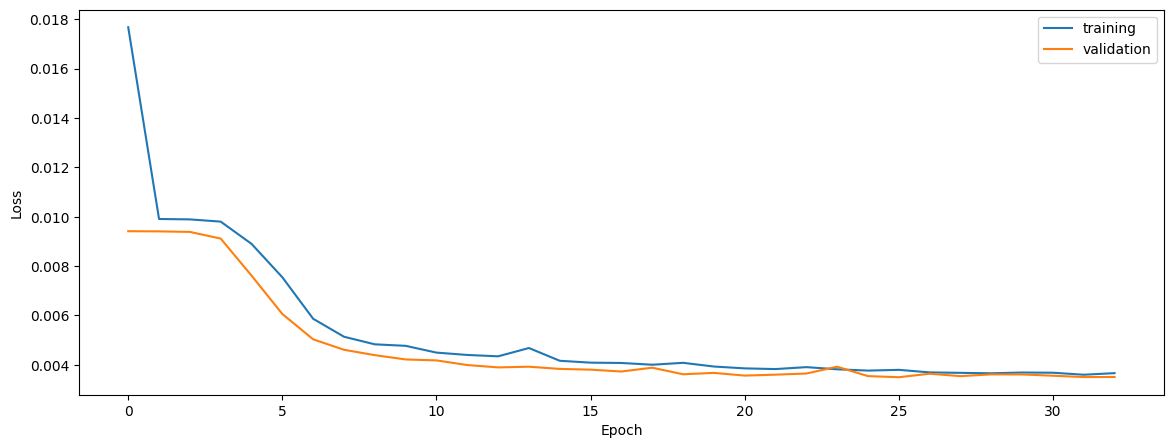

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train.append(predictInBatches(model,train[0],architecture['batch_size']))
val.append(predictInBatches(model,val[0],architecture['batch_size']))
test.append(predictInBatches(model,test[0],architecture['batch_size']))

print('train')
print(getPearson(train[1],train[4]))
print(getPearson(val[1],val[4]))
print(getPearson(test[1],test[4]))

train
0.6126073009178127
0.6181728736209676
0.6299688502487331


In [8]:
print(props['space'])
print(getPearson(train[1],train[4],train[3][0]))
print(getPearson(val[1],val[4],val[3][0]))
print(getPearson(test[1],test[4],test[3][0]))

native
0.6132740459053218
0.6179799582434619
0.632156061580729


In [9]:
print('normalized' if props['space'] == 'native' else 'native')
print(getPearson(train[1][train[2]],train[4][train[2]],train[3][1]))
print(getPearson(val[1][val[2]],val[4][val[2]],val[3][1]))
print(getPearson(test[1][test[2]],test[4][test[2]],test[3][1]))

normalized
0.6253963501365788
0.6401718035268954
0.661180522987439


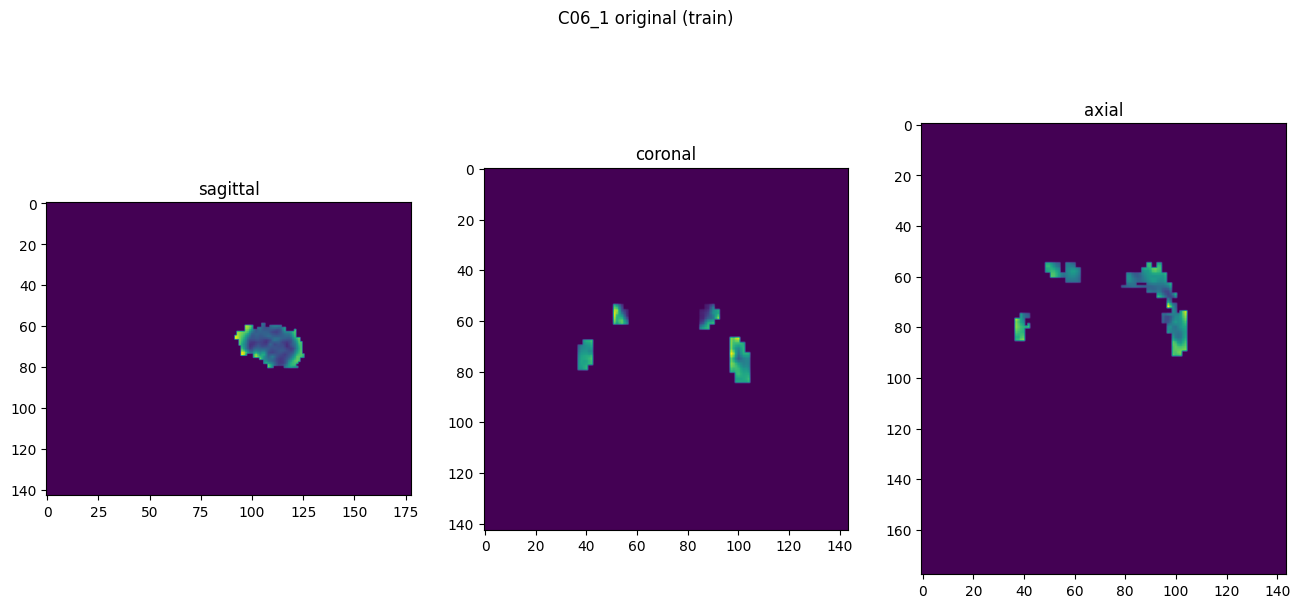

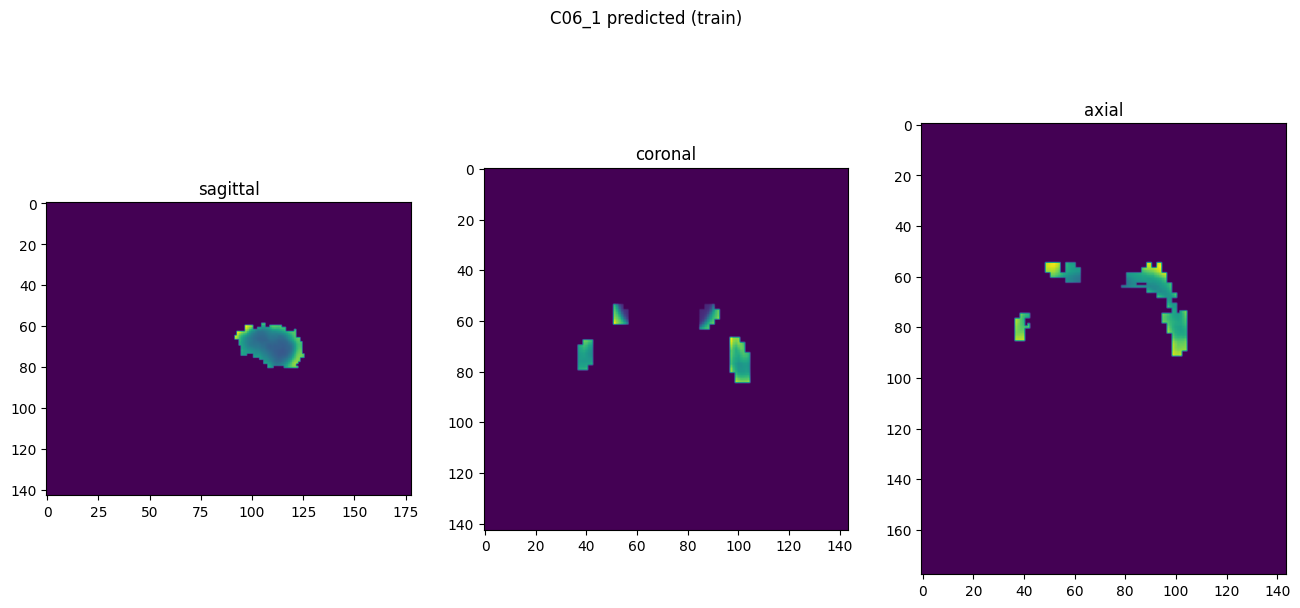

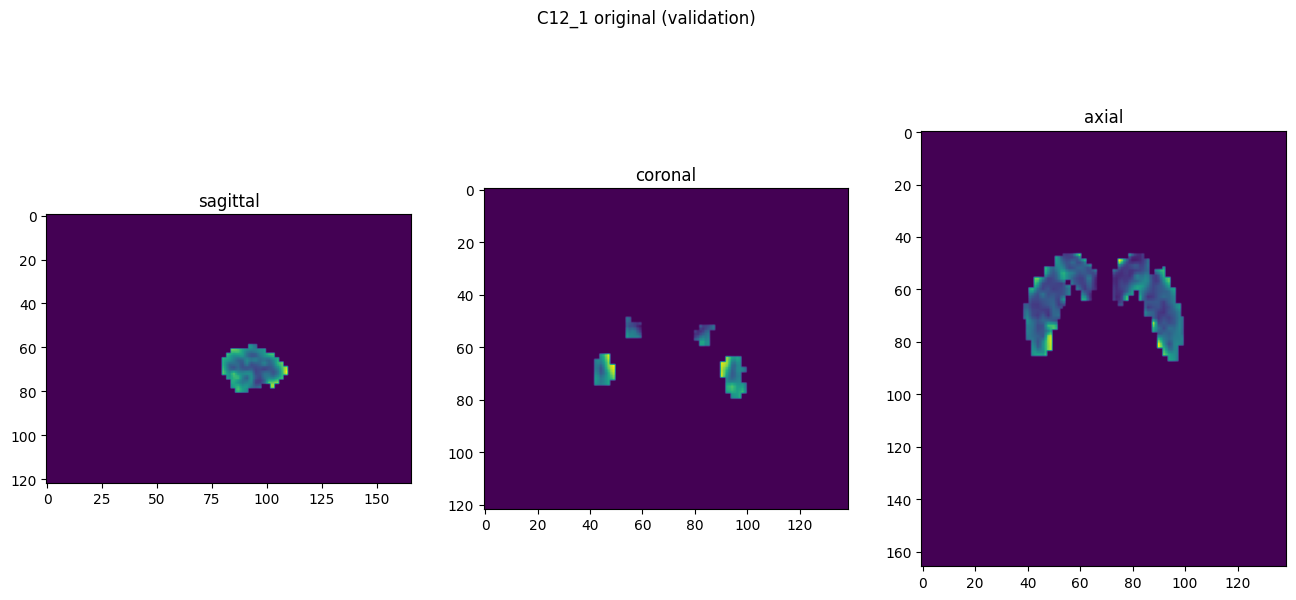

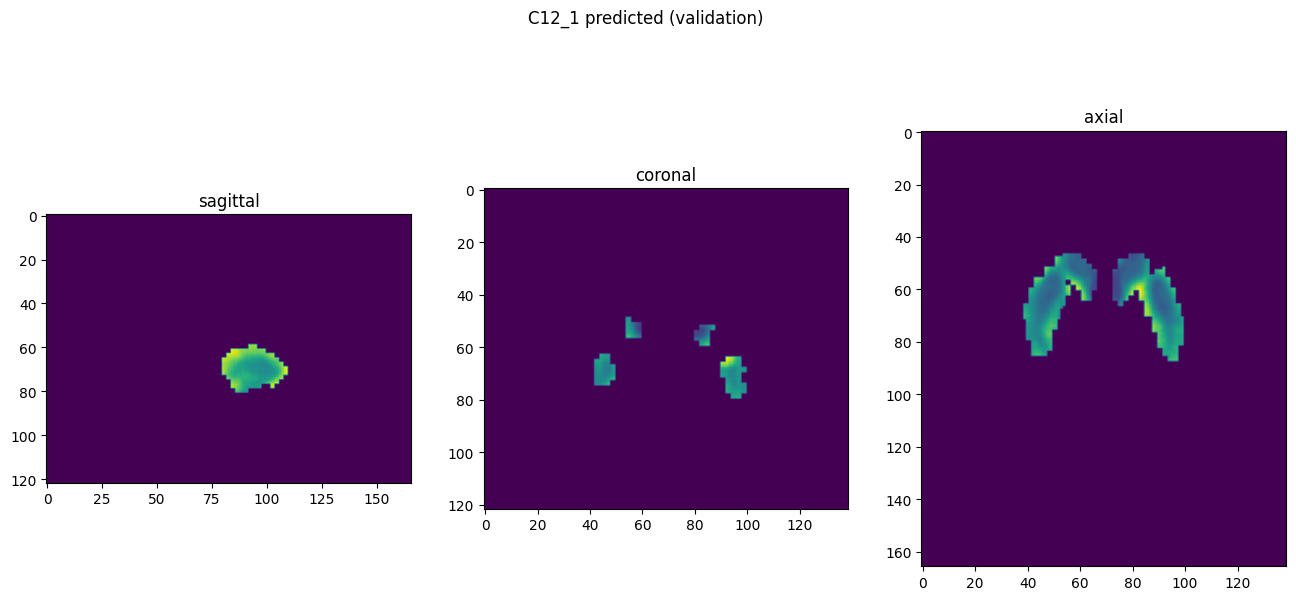

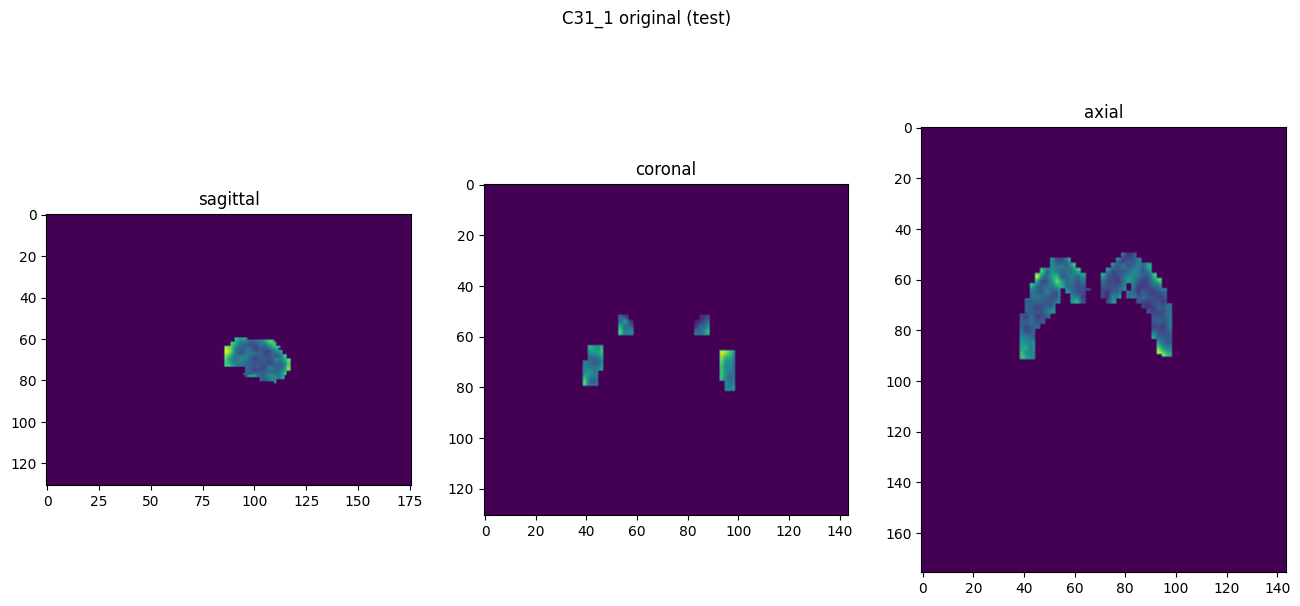

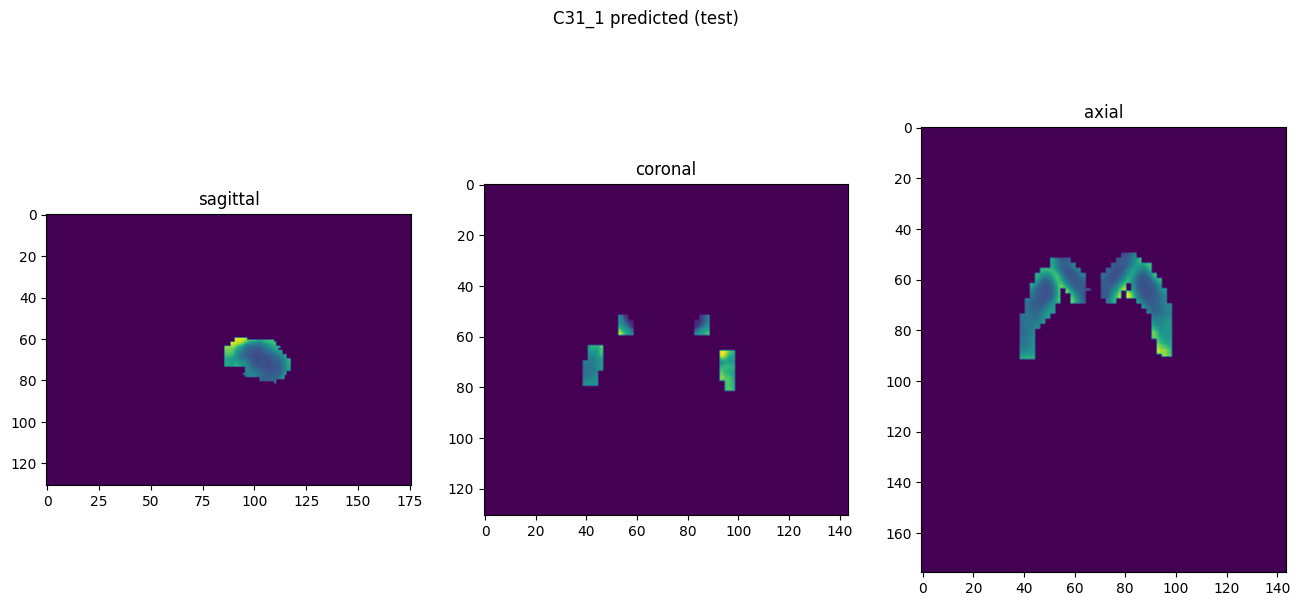

In [10]:
showResults(model, gen, threshold=None, background=False)